# Import Code

In [ ]:
# These are all of the imports we used for the project to analyze and plot our results.
import pandas as pd
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Collection and Refinement

## Construct Fetch Document Class

In [ ]:
import concurrent.futures
import time
from datetime import datetime, timedelta
import logging
import uuid

import pandas as pd
import requests


start_time = time.time()
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

DATETIME_FORMAT = "%d/%m/%Y"


class FetchDocument:
    def __init__(self,
                 after_source_datetime,
                 before_source_datetime=datetime.today().strftime(DATETIME_FORMAT),
                 root_file_path=None,
                 documents_filename=None,
                 metadata_filename=None,
                 skip_count=500):
        yesterday = datetime.today() - timedelta(days=1)

        if after_source_datetime is None or after_source_datetime == "":
            after_source_datetime = yesterday.strftime(DATETIME_FORMAT)

        if documents_filename == "" or documents_filename is None or metadata_filename == "" or metadata_filename is None:
            documents_filename = f"{datetime.today().strftime('%d%m%Y')}_documents.csv"
            metadata_filename = f"{datetime.today().strftime('%d%m%Y')}_metadata.csv"

        self.ROOT_FILE_PATH = root_file_path
        self.documents_filepath = f"{self.ROOT_FILE_PATH}/{documents_filename}"
        self.metadata_filepath = f"{self.ROOT_FILE_PATH}/{metadata_filename}"
        self.URL = "https://www.conseil-etat.fr/xsearch?type=json"
        self.SKIP_COUNT = skip_count
        self.skip_from = 0
        self.DOCUMENT_PROCESSED = 0
        self.TOTAL_COUNT = 0
        self.PAGE_COUNT = 0

        self.TOTAL_COUNT = 0
        self.PAGE_COUNT = 0

        self.documents = []
        self.metadata_list = []

        self.after_source_datetime = after_source_datetime
        self.before_source_datetime = before_source_datetime

    def print_progress(self, current_page):
        logger.info(f'{current_page}/{self.PAGE_COUNT}')
        logger.info("progress:" + str(round(current_page / self.PAGE_COUNT, 2) * 100) + "%")

    def export(self):
        logger.info(f"Status: EXPORTING TO CSV")

        df_documents = pd.DataFrame(self.documents)
        df_metadata = pd.DataFrame(self.metadata_list)

        df_documents.to_csv(self.documents_filepath, index=False)
        df_metadata.to_csv(self.metadata_filepath, index=False)

        logger.info(f"Status: EXPORTED TO CSV: {self.documents_filepath}")
        logger.info(f"Status: EXPORTED TO CSV: {self.metadata_filepath}")

    def fetch(self, skip_from):
        try:
            logger.info(f"FETCH SKIP_FROM {skip_from}/{self.TOTAL_COUNT}: Status FETCHING")
            response = requests.post(self.URL, data={
                "advanced": 1,
                "type": "json",
                "SourceStr4": "AW_DCE",
                "synonyms": "true",
                "scmode": "smart",
                "SkipCount": self.SKIP_COUNT,
                "SkipFrom": skip_from,
                "Engine": "engine2",
                "aftersourcedatetime1": self.after_source_datetime,
                "beforesourcedatetime1": self.before_source_datetime,
            })

            response.raise_for_status()

            logger.info(f"FETCH SKIP_FROM {skip_from}/{self.TOTAL_COUNT}: Status DONE")
            return response.json()
        except Exception as e:
            with open("../datasets/errors.txt", "a") as f:
                f.write(f"FETCH SKIP_FROM {skip_from}/{self.TOTAL_COUNT}: Status ERROR\n")
                f.write(str(e) + "\n")

            logger.error(f"FETCH SKIP_FROM {skip_from}/{self.TOTAL_COUNT}: Status ERROR")
            logger.error(e)

    def get_documents(self, response, fetch_id):
        logger.info(f"{fetch_id}: Status PROCESSING")
        documents = response["Documents"]
        logger.info(f"Page {response['CurrentPage']}: Status PROCESSING")
        for document in documents:
            document["FetchId"] = fetch_id
            document["FetchDateTime"] = pd.to_datetime(response["Timestamp"])
            document["Engine"] = response["Engine"]
            yield document
        self.DOCUMENT_PROCESSED += len(documents)
        logger.info(f"Page {response['CurrentPage']}: Status PROCESSED")
        logger.info(
            f"Page {response['CurrentPage']}: Total processed documents: {self.DOCUMENT_PROCESSED}/{self.TOTAL_COUNT}")

        logger.info(f"{fetch_id}: Status DONE")

    def get_metadata(self, response, fetch_id):
        logger.info(f"{fetch_id}: Status PROCESSING")
        if boxes := response.get("Boxes"):
            if query := response.get("Query"):
                if advanced := query.get("Advanced"):
                    for box in boxes:
                        result = {
                            "FetchId": fetch_id,
                            "FetchDateTime": pd.to_datetime(response["Timestamp"]),
                            "Engine": response["Engine"],
                            "Advanced": advanced[0]
                        }

                        for node in box["Nodes"]:
                            logger.info(f"Node: {node['Name']}: {node['Value']}")
                            tmp = {
                                "BoxType": box["BoxType"],
                                "BoxName": box["Name"],
                                "NodeName": node["Name"],
                                "NodeTreepath": node["Treepath"],
                                "NodeValue": node["Value"]
                            }
                            yield tmp | result

    def process(self):
        response = self.fetch(0)
        self.TOTAL_COUNT = response["TotalCount"]
        self.PAGE_COUNT = response["PageCount"]

        with concurrent.futures.ThreadPoolExecutor(max_workers=100) as executor:
            future_to_url = {executor.submit(self.fetch, skip_from): skip_from for skip_from in
                             range(0, self.TOTAL_COUNT, self.SKIP_COUNT)}
            for future in concurrent.futures.as_completed(future_to_url):
                data = future.result()
                fetch_id = str(uuid.uuid4())
                if data:
                    self.documents.extend(self.get_documents(data, fetch_id))
                    self.metadata_list.extend(self.get_metadata(data, fetch_id))
                    logger.info(f"Page {data['CurrentPage']}: Status DONE")
                    # logger.info(f"Page {data['CurrentPage']}: Status SLEEPING")
                    # sleep(5)
                    # logger.info(f"Page {data['CurrentPage']}: Status FINISHED")
                else:
                    logger.error("Error")

    def run(self):
        self.process()
        self.export()
        print("--- %s seconds ---" % (time.time() - start_time))

## Construct Refine Metadata Class

In [ ]:
import time

import pandas as pd
import logging

# %%
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# %%
start_time = time.time()


class RefineMetadata:

    def __init__(
            self,
            input_path="../datasets/csv",
            input_filename="metadata.csv",
            export_path="../datasets/csv",
            export_filename="refined_metadata.csv"
    ):

        self.metadata_df = pd.read_csv(
            f"{input_path}/{input_filename}",
            low_memory=False,
        )
        logger.info(f"Import Shape: {self.metadata_df.shape}")
        self.export_path = export_path
        self.export_filename = export_filename

    def extract_value(self, row):

        # "codePCJA;sourcetree1;/41/;Monuments et sites."
        # "(box_name);(column_name);(column_value);(column_label_word_not_number)"
        logger.info(f"Extracting value: {row['NodeValue']}")
        node_values = row["NodeValue"].replace("\"", "").replace("\\", "").split(";")
        row["RefinedNodeLabel"] = node_values[1]
        if len(node_values) > 2:
            row["RefinedNodeValue"] = node_values[3]
        else:
            row["RefinedNodeValue"] = node_values[-1]
        logger.info(f"Extracted value: {row['RefinedNodeValue']}")
        return row

    def process(self):
        self.metadata_df = self.metadata_df.apply(self.extract_value, axis=1)
        self.metadata_df.dropna(inplace=True)
        self.metadata_df.drop_duplicates(inplace=True)

    def export(self):
        logger.info(f"Status: EXPORTING TO CSV")
        self.metadata_df.to_csv(
            f"{self.export_path}/{self.export_filename}",
            index=False
        )
        logger.info(f"Exported to: {self.export_path}/{self.export_filename}")

    def run(self):
        self.process()
        self.export()
        print("--- %s seconds ---" % (time.time() - start_time))



## Construct Refine Document Class

In [ ]:
import time

import numpy as np
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

start_time = time.time()


class RefineDocument:

    def __init__(
            self,
            document_filepath="../datasets/csv/documents.csv",
            refined_metadata_filepath="../datasets/csv/refined_metadata.csv",
            export_path="../datasets/csv",
            export_filename="refined_documents.csv"
    ):
        self.document_filename = document_filepath
        self.refined_metadata_filepath = refined_metadata_filepath
        self.export_path = export_path
        self.export_filename = export_filename
        self.document_df = pd.read_csv(
            self.document_filename,
            low_memory=False,
        )

        logger.info(f"Status: {self.document_df.shape}")

        self.metadata_df = pd.read_csv(
            self.refined_metadata_filepath,
            low_memory=False,
            usecols=["BoxName", "NodeName", "RefinedNodeLabel", "RefinedNodeValue"]
        )
        logger.info(f"Status: {self.metadata_df.shape}")

        self.code_pjca_df = self.metadata_df[self.metadata_df["BoxName"] == "codePCJA"]

    def process_geo(self, geo):
        tmp = str(geo)
        results = []
        logger.info(f"Processing geo: {tmp}: START")
        for item in tmp.split(";"):
            if str(item).isupper():
                results.append(item)
        if len(results) > 0:
            data = ';'.join(list(set(results)))
            logger.info(f"Processed geo: {tmp}: {data}")
            return data
        else:
            logger.info(f"Processed geo: {tmp}: {np.nan}")
            return np.nan

    def process_company(self, company):
        tmp = str(company)
        results = []
        logger.info(f"Processing geo: {tmp}: START")
        for item in tmp.split(";"):
            if str(item).isupper():
                results.append(item)
        if len(results) > 0:
            data = ';'.join(list(set(results)))
            logger.info(f"Processed company: {tmp}: {data}")
            return data
        else:
            logger.info(f"Processed company: {tmp}: {np.nan}")
            return np.nan

    def process_sector(self, sector):
        tmp = str(sector)
        results = []
        logger.info(f"Processing sector: {tmp}: START")
        for item in str(sector).split(";"):
            item = str(item.replace("/", ""))
            logger.info(f"Processing sector: {tmp}: {item}")
            if item in self.code_pjca_df["NodeName"].values:
                sector_list = self.code_pjca_df[self.code_pjca_df["NodeName"] == item]["RefinedNodeValue"].values
                for sector_item in sector_list:
                    logger.info(f"Processing sector: {tmp}: {sector_item}")
                    if type(sector_item) is float:
                        logger.info(f"Processing sector: {tmp}: {sector_item}: SKIP")
                        continue
                    sector_item = str(sector_item)
                    results.append(sector_item)
        if len(results) > 0:
            data = ';'.join(list(set(results)))
            logger.info(f"Processed sector: {tmp}: {data}")
            return data
        else:
            logger.info(f"Processed sector: {tmp}: {np.nan}")
            return np.nan

    def export(self):
        logger.info(f"Status: EXPORTING TO CSV")
        self.document_df.to_csv(
            f"{self.export_path}/{self.export_filename}",
            index=False
        )
        logger.info(f"Exported to: {self.export_path}/{self.export_filename}")

    def run(self):
        logger.info(f"Status: PROCESSING")
        self.document_df["RefinedCompany"] = self.document_df["Company"].apply(self.process_company)
        self.document_df["RefinedGeo"] = self.document_df["Geo"].apply(self.process_geo)
        self.document_df["RefinedSector"] = self.document_df["SourceTree1"].apply(self.process_sector)
        logger.info(f"Status: PROCESSED")
        logger.info(f"Status: EXPORTING")
        self.export()
        logger.info(f"Status: EXPORTED")
        logger.info(f"Status: COMPLETED")
        print("--- %s seconds ---" % (time.time() - start_time))

## Initialize file path

In [ ]:
import os
workspace_path = "/content/drive/MyDrive/LDA_Final"
dataset_filename= "decisions.csv"
refined_dataset_filename= "refined_decisions.csv"
metadata_filename= "metadata.csv"
refined_metadata_filename = "refined_metadata.csv"

if not os.path.exists(workspace_path):
  os.mkdir(f"{workspace_path}")

## Run

In [ ]:
fetch_document = FetchDocument(
    root_file_path=workspace_path,
    after_source_datetime="01/01/1800",
    before_source_datetime="11/12/2023",
    documents_filename=dataset_filename,
    metadata_filename=metadata_filename,
    skip_count=500,

)
fetch_document.run()

--- 352.2339508533478 seconds ---


In [ ]:
refineMataData = RefineMetadata(
 export_path=workspace_path,
 input_path=workspace_path,
)
refineMataData.run()

--- 468.27885913848877 seconds ---


In [ ]:
process_document = RefineDocument(
    export_path=workspace_path,
    document_filepath=f"{workspace_path}/{dataset_filename}",
    refined_metadata_filepath=f"{workspace_path}/{refined_metadata_filename}",
    export_filename=refined_dataset_filename
)
process_document.run()

--- 1101.2469747066498 seconds ---


# Dataframe Preparation

## Load Refined Data

In [ ]:
# Loading our dataset into a dataframe with only certain columns for analysis purposes.
df = pd.read_csv(f"{workspace_path}/{refined_dataset_filename}", low_memory=False, usecols=["Id","Rank", "Size", "RefinedGeo", "SourceCsv1", "SourceStr7", "SourceStr8", "SourceStr12", "SourceDateTime1", "SourceInt1", "Engine", "SourceStr21", "RefinedCompany", "RefinedSector", "SourceDateTime2"])

## Explore Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158795 entries, 0 to 158794
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Id               158795 non-null  object
 1   Rank             158795 non-null  int64 
 2   Size             158795 non-null  int64 
 3   SourceCsv1       158795 non-null  object
 4   SourceStr8       158751 non-null  object
 5   SourceStr12      77043 non-null   object
 6   SourceStr21      35500 non-null   object
 7   SourceDateTime1  158795 non-null  object
 8   SourceInt1       158795 non-null  int64 
 9   Engine           158795 non-null  object
 10  SourceStr7       150687 non-null  object
 11  SourceDateTime2  65252 non-null   object
 12  RefinedCompany   11267 non-null   object
 13  RefinedGeo       154182 non-null  object
 14  RefinedSector    86846 non-null   object
dtypes: int64(3), object(12)
memory usage: 18.2+ MB


In [ ]:
df.describe()

,Rank,Size,SourceInt1
count,158795.000000,158795.000000,158795.000000
mean,79397.000000,7297.877880,1999.232677
std,45840.312335,4887.356389,528.419193
min,0.000000,41.000000,0.000000
25%,39698.500000,4366.000000,1990.000000
50%,79397.000000,6090.000000,1999.000000
75%,119095.500000,8760.500000,2010.000000
max,158794.000000,304657.000000,211341.000000


In [ ]:
df.head()

,Id,Rank,Size,SourceCsv1,SourceStr8,SourceStr12,SourceStr21,SourceDateTime1,SourceInt1,Engine,SourceStr7,SourceDateTime2,RefinedCompany,RefinedGeo,RefinedSector
0,/Ariane_Web/AW_DCE/|81117,1500,5521,64995,A,Rejet rejet recours incident,Défaut de surveillance de l'architecte : respo...,1968-10-16 02:00:00,1968,engine2,NaN,NaN,NaN,LYON;MACON;SAINT-CLEMENT;REPUBLIQUE FRANCAISE,Marchés et contrats administratifs.
1,/Ariane_Web/AW_DCE/|80686,1501,4504,99847,B,REJET Droits maintenus,Activités liées à l'agriculture - Absence d'ex...,1977-10-05 02:00:00,1977,engine2,Autres CHR,NaN,NaN,REPUBLIQUE FRANCAISE;AMIENS;FRANCE;OISE,Contributions et taxes.
2,/Ariane_Web/AW_DCE/|86056,1502,9540,157850;157851;157852,B,Rejet,NaN,1997-04-23 02:00:00,1997,engine2,Autres CHR,NaN,NaN,CANNES;VILLEFRANCHE-SUR-MER;LYON;NICE;COTE-D '...,NaN
3,/Ariane_Web/AW_DCE/|80688,1503,8360,06656,B,REJET,Libéralité consentie par une société visée à l...,1981-04-24 02:00:00,1981,engine2,Autres CHR,NaN,NaN,GRENOBLE;REPUBLIQUE FRANCAISE,Contributions et taxes.
4,/Ariane_Web/AW_DCE/|87978,1504,9252,257031,B,NaN,Assimilation d'un visa de long séjour à un vis...,2005-01-12 01:00:00,2005,engine2,10-9 CHR,2003-05-20 02:00:00,NaN,FRANCE;ALPES-MARITIMES;PARIS;NICE;ITALIE;PORTU...,Étrangers.


In [ ]:
df[df.duplicated("Id")].head()

,Id,Rank,Size,SourceCsv1,SourceStr8,SourceStr12,SourceStr21,SourceDateTime1,SourceInt1,Engine,SourceStr7,SourceDateTime2,RefinedCompany,RefinedGeo,RefinedSector
2025,/Ariane_Web/AW_DCE/|84691,25,4873,00869,A,Annulation totale,Entrepreneur et maître d'ouvrage - Clause excl...,1977-12-02 01:00:00,1977,engine2,Autres CHR,NaN,NaN,EVIAN-LES-BAINS;REPUBLIQUE FRANCAISE;GRENOBLE;...,Marchés et contrats administratifs.
2027,/Ariane_Web/AW_DCE/|80758,27,7208,40579,A,Annulation totale,Charges étrangères ou non à l'intérêt de l'ent...,1984-07-27 02:00:00,1984,engine2,Autres CHR,NaN,NaN,REPUBLIQUE FRANCAISE;LILLE,Contributions et taxes.
2028,/Ariane_Web/AW_DCE/|84792,28,3802,31667,B,REJET Incompétence,Régimes spéciaux - Décision administrative inh...,1981-10-02 02:00:00,1981,engine2,Autres CHR,NaN,ARMEE DE TERRE,MARSEILLE;BOUCHES-DU-RHONE;REPUBLIQUE FRANCAISE,Sécurité sociale.;Compétence.
2029,/Ariane_Web/AW_DCE/|87320,29,8816,244176,B,Satisfaction partielle,Registre des immobilisations affectées à l'exe...,2004-07-28 02:00:00,2004,engine2,3-8 CHR,2002-03-18 01:00:00,NaN,REPUBLIQUE FRANCAISE;PARIS;LOGNES;MELUN,Contributions et taxes.
2030,/Ariane_Web/AW_DCE/|76177,30,3486,69168,B,Rejet,NaN,1988-06-17 02:00:00,1988,engine2,Autres CHR,NaN,NaN,CAEN;LYON;NICE;VAR;REPUBLIQUE FRANCAISE,NaN


In [ ]:
print(len(df[df.duplicated("Id")]))
print(len(df))

df[df["Id"] == "/Ariane_Web/AW_DCE/|80871"]

4845
158795


,Id,Rank,Size,SourceCsv1,SourceStr8,SourceStr12,SourceStr21,SourceDateTime1,SourceInt1,Engine,SourceStr7,SourceDateTime2,RefinedCompany,RefinedGeo,RefinedSector
1929,/Ariane_Web/AW_DCE/|80871,929,9465,61551,B,Rejet,NaN,1988-06-29 02:00:00,1988,engine2,Autres CHR,NaN,NaN,AMIENS;FRANCE;REPUBLIQUE FRANCAISE,NaN
32506,/Ariane_Web/AW_DCE/|80871,7506,9465,61551,B,Rejet,NaN,1988-06-29 02:00:00,1988,engine2,Autres CHR,NaN,NaN,AMIENS;FRANCE;REPUBLIQUE FRANCAISE,NaN


## Clean Data

### Remove Duplicated Data

In [ ]:
df.drop(columns=["Rank"], inplace=True)
df.drop_duplicates(inplace=True)

In [ ]:
print(len(df[df.duplicated("Id")]))
print(len(df))
#
# print(len(prepared_df[prepared_df.duplicated("Id")]))
# print(len(prepared_df))

0
153950


In [ ]:
# This code renames the columns so that they can be analyzed and graphed easier.
prepared_df = df.rename(columns={
    "Id": "Ariane Web Id",
    "Size": "File Size",
    "RefinedGeo": "Legal Entity Location",
    "SourceCsv1": "Case File Number",
    "SourceStr7": "Reviewing Chamber",
    "SourceStr8": "Publication Code",
    "SourceStr12": "Case Outcome",
    "SourceDateTime1": "Full Date",
    "SourceInt1": "Year Date",
    "RefinedSector": "Legal Sector",
    "RefinedCompany": "Legal Entity",
    "SourceStr21": "Legal Notes and Conclusions",
})

# This code adds a new column titled Shortened Legal Entity to make it easier to count the Number of Appearances each legal entity has made before the Conseil.
# We chose to do this because otherwise, the legal entity could be counted twice for graphing purposes.
prepared_df["Legal Entity"] = prepared_df["Legal Entity"].str.split(";").str[0]

# This code adds a new column called "Number of Appearances" which tallies up the number of times a legal entity has argued before the Conseil.
prepared_df["Number of Appearances"] = prepared_df["Legal Entity"].map(prepared_df["Legal Entity"].value_counts())

# This code alters the column order to make our dataset easier to read/understand, as well as less cluttered by reducing our column width.
new_column_order = [
    "Legal Entity", "Legal Entity Location", "Legal Sector", "Reviewing Chamber",
    "Case Outcome", "Publication Code", "Full Date", "Year Date",
    "Number of Appearances", "Legal Notes and Conclusions", "Ariane Web Id",
    "File Size", "Case File Number", "Engine", "SourceDateTime2"
]

prepared_df = prepared_df[new_column_order]
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# This code provides the results of the legal entity and number of appearences that can be used for data visualization purposes.
legal_entity_counts_df = prepared_df["Legal Entity"].value_counts().reset_index()
legal_entity_counts_df.columns = ["Legal Entity", "Number of Appearances"]


## Save

In [ ]:
# This code makes all abovementioned alterations to the original dataset and makes a modified file path for our data analysis and visualization work.
output_filename = "Modified_Refined.csv"
prepared_df.to_csv(f"{workspace_path}/{output_filename}", index=False)


# Data Analysis and Visualization Code

## RESEARCH QUESTIONS
### Are there any legal entities that argue often before the Conseil d'État and, if so, what types of cases do they argue, are those cases published, and what is their success rate?
--------

### 1.HOW MANY TIMES HAVE LEGAL ENTITIES ARGUED BEFORE THE CONSEIL?


This graph plots the total number of times each legal entity has appeared before the Conseil d'État.



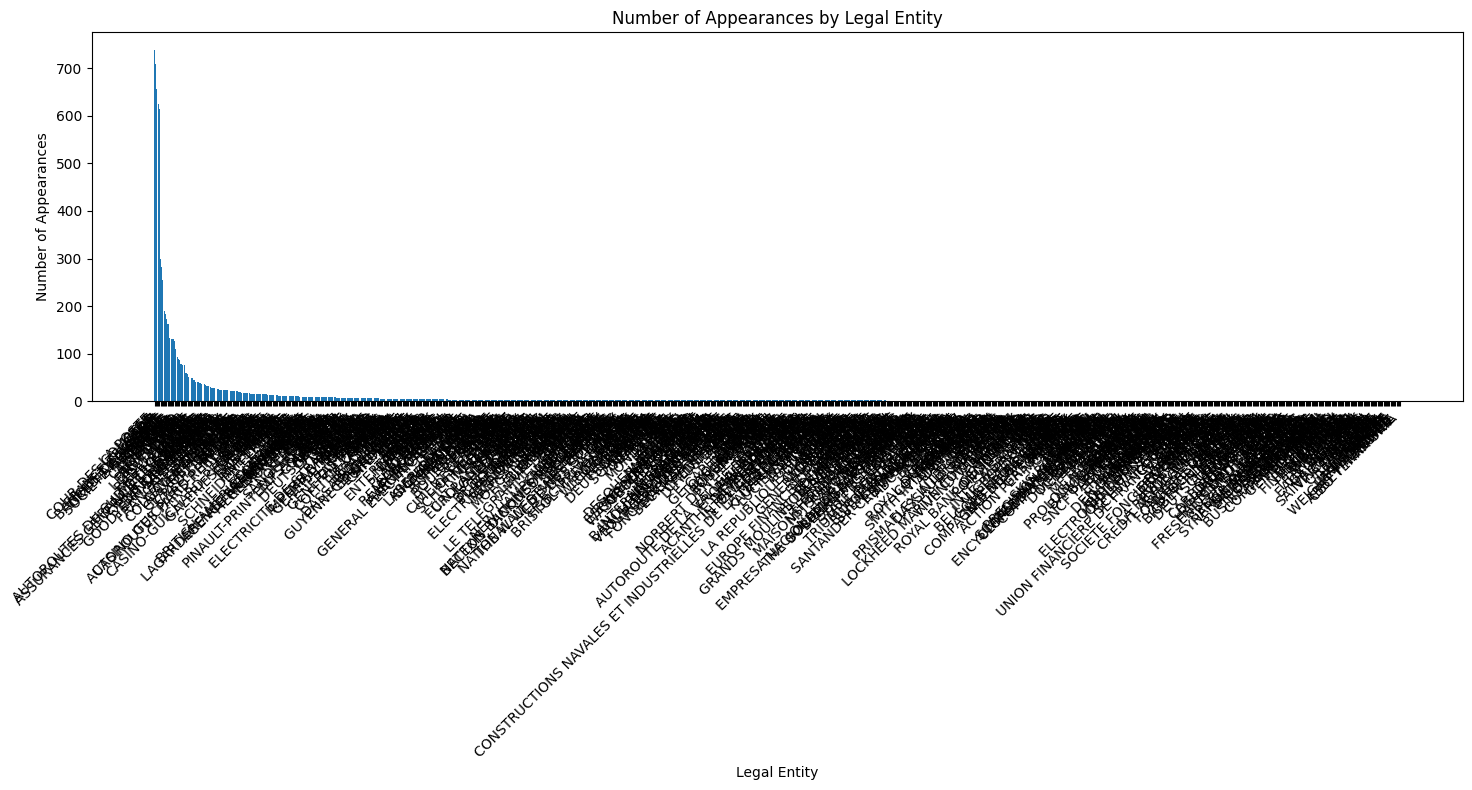



As you can see, analyzing the 1056 unique legal entities across the 153950 decisions in the database, is a bit more difficult if you don't narrow your focus.

Another way to view this data more clearly is to view the value counts. Below, you can view the top 40 legal entities ranked by the number of times they have argued before the Conseil.


        Legal Entity  Number of Appearances
0           LA POSTE                    738
1   COUR DES COMPTES                    709
2               CFDT                    655
3                EDF                    624
4                CGT                    614
5               SNCF                    300
6     FRANCE TELECOM                    282
7   BANQUE DE FRANCE                    254
8              SENAT                    190
9    CREDIT AGRICOLE                    184
10        AIR FRANCE                    173
11               GDF                    163
12  SOCIETE GENERALE                    163
13          FACEBOOK                

In [ ]:
def total_appearances(prepared_df):
  print("\nThis graph plots the total number of times each legal entity has appeared before the Conseil d'État.")
  print("")
  plt.figure(figsize=(15, 8))
  plt.bar(legal_entity_counts_df["Legal Entity"], legal_entity_counts_df["Number of Appearances"])
  plt.xlabel("Legal Entity")
  plt.ylabel("Number of Appearances")
  plt.title("Number of Appearances by Legal Entity")
  plt.xticks(rotation=45, ha="right")
  plt.tight_layout()
  plt.show()
  print("\n")

total_appearances(prepared_df)

unique_legal_entities_count = prepared_df["Legal Entity"].nunique()
unique_case_numbers_count = prepared_df["Ariane Web Id"].nunique()

print(f"As you can see, analyzing the {unique_legal_entities_count} unique legal entities across the {unique_case_numbers_count} decisions in the database, is a bit more difficult if you don't narrow your focus.")
print("")
print("Another way to view this data more clearly is to view the value counts. Below, you can view the top 40 legal entities ranked by the number of times they have argued before the Conseil.")
print("\n")
print(legal_entity_counts_df.head(40))


### 3.HOW OFTEN HAVE THE TOP 10 LEGAL ENTITIES APPEARED BEFORE THE CONSEIL's CHAMBERS?


This graph plots the number of times the top 10 legal entities have appeared before the Conseil d'État by year.



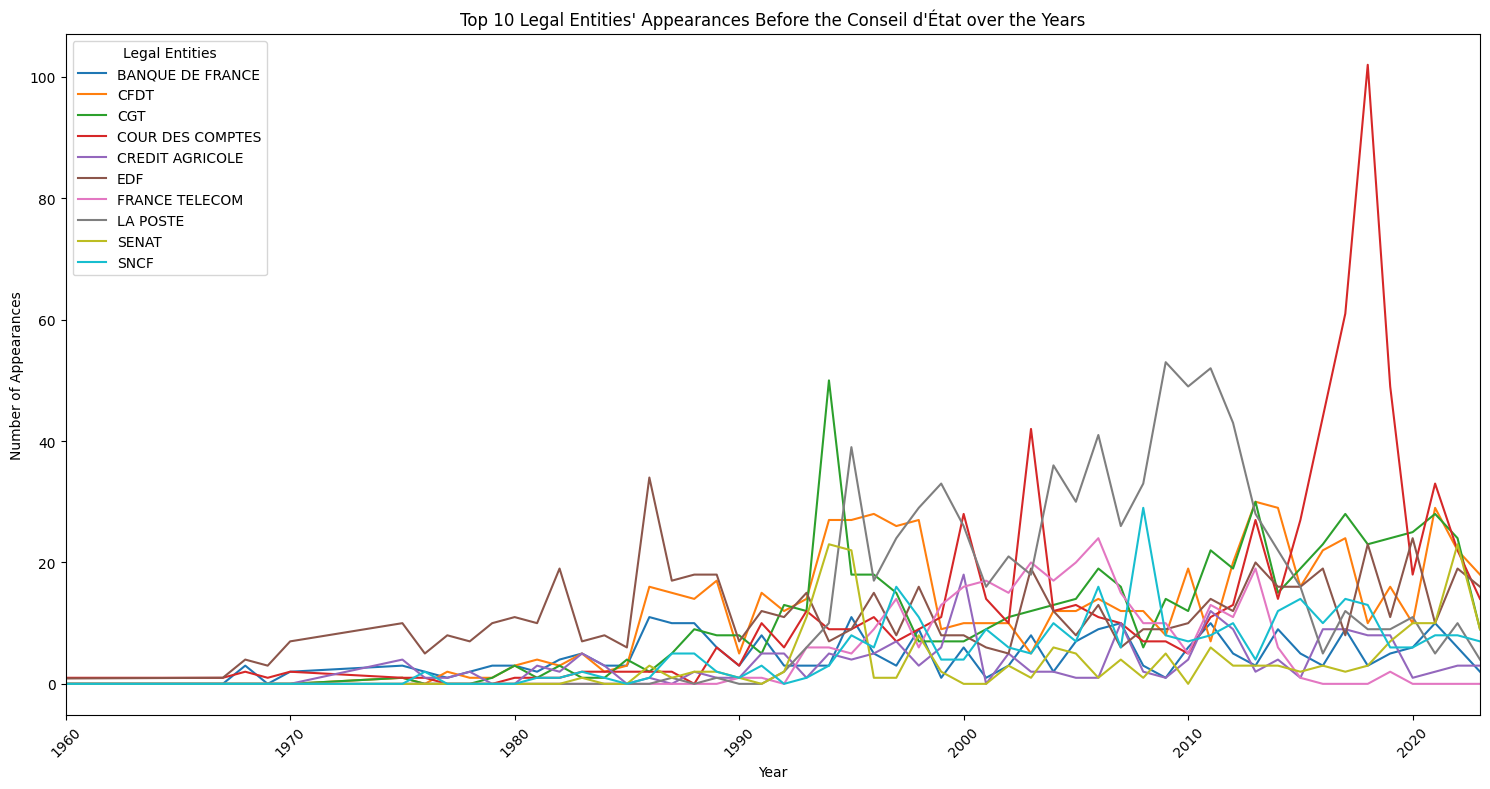

In [ ]:
def top_10_appearences(prepared_df):
  print("\nThis graph plots the number of times the top 10 legal entities have appeared before the Conseil d'État by year.")
  print("")
  top_ten_entities = prepared_df["Legal Entity"].value_counts().head(10).index
  filtered_df = prepared_df[prepared_df["Legal Entity"].isin(top_ten_entities)]
  grouped_data = filtered_df.groupby(["Year Date", "Legal Entity"]).size().reset_index(name="Number of Appearances")
  pivot_df = grouped_data.pivot(index="Year Date", columns="Legal Entity", values="Number of Appearances").fillna(0)
  plt.figure(figsize=(15, 8))
  for entity in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[entity], label=entity)
  plt.xlabel("Year")
  plt.ylabel("Number of Appearances")
  plt.title("Top 10 Legal Entities' Appearances Before the Conseil d'État over the Years")
  plt.legend(title="Legal Entities", loc="upper left")
  plt.xticks(rotation=45)
  plt.xlim(1960, pivot_df.index.max())
  plt.tight_layout()
  plt.show()
  print("")

top_10_appearences(prepared_df)


### 4.WHICH LEGAL SECTORS HAVE THE TOP 10 LEGAL ENTITIES ARGUED BEFORE THE CONSEIL?


This graph analyzes the number of cases the top 10 legal entities have argued before the Conseil classified by the legal sector.



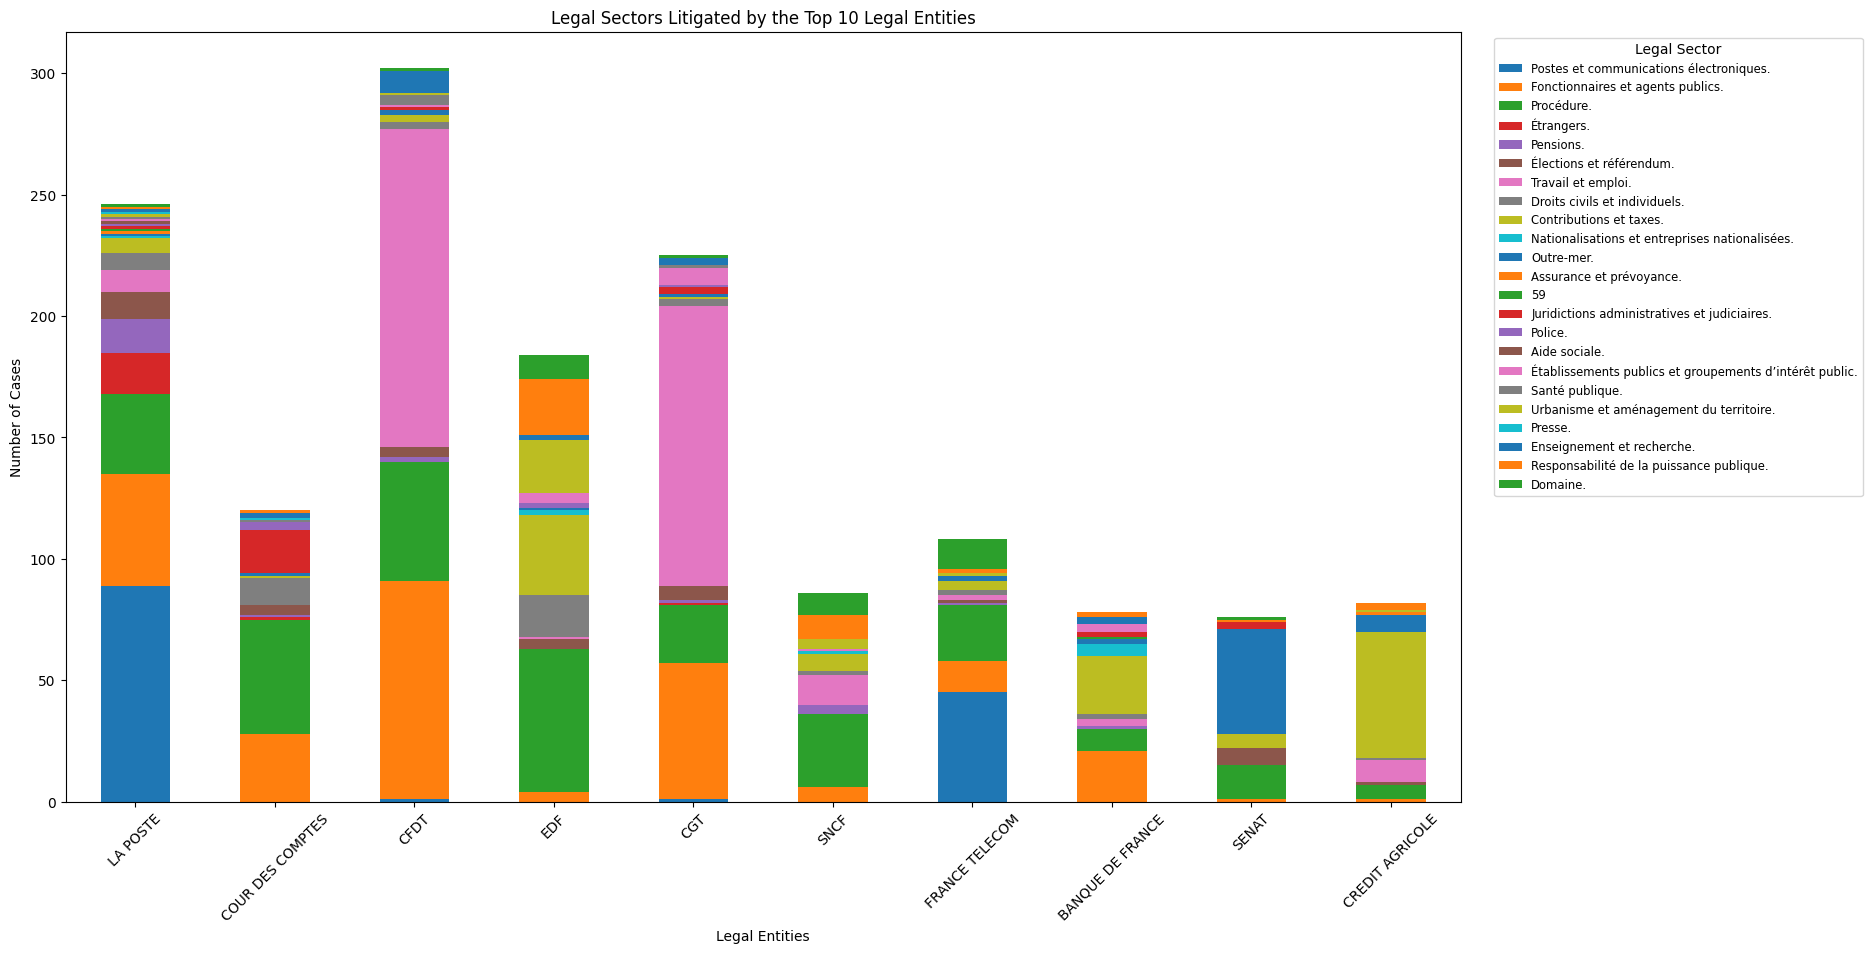

In [ ]:
def top_10_subject_analysis(prepared_df):
    print("\nThis graph analyzes the number of cases the top 10 legal entities have argued before the Conseil classified by the legal sector.")
    print("")
    top_ten_entities =prepared_df["Legal Entity"].value_counts().head(10).index
    sector_counts = pd.DataFrame()
    # We used ChatGPT to help split the values in the Legal Sector column so that only the first code would be counted, thus making a broader analysis possible.
    for entity in top_ten_entities:
        entity_df =prepared_df[prepared_df["Legal Entity"] == entity].copy()
        entity_df["Primary Legal Sector"] = entity_df["Legal Sector"].str.split(";").str[0]
        sectors = entity_df["Primary Legal Sector"].value_counts()
        sector_counts[entity] = sectors
    sector_counts = sector_counts.T.fillna(0)
    fig, ax = plt.subplots(figsize=(18,10))
    sector_counts.plot(kind="bar", stacked=True, ax=ax)
    ax.set_xlabel("Legal Entities")
    ax.set_ylabel("Number of Cases")
    ax.set_title("Legal Sectors Litigated by the Top 10 Legal Entities")
    plt.xticks(rotation=45)
    ax.legend(title="Legal Sector", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize="small")
    plt.show()

top_10_subject_analysis(prepared_df)


### 5.WHERE ARE LEGAL ENTITIES MOST COMMONLY LOCATED?


There are 5136 unique locations in the 'Legal Entity Location' column.

This graph compiles the most common locations where a legal entity is based in France.



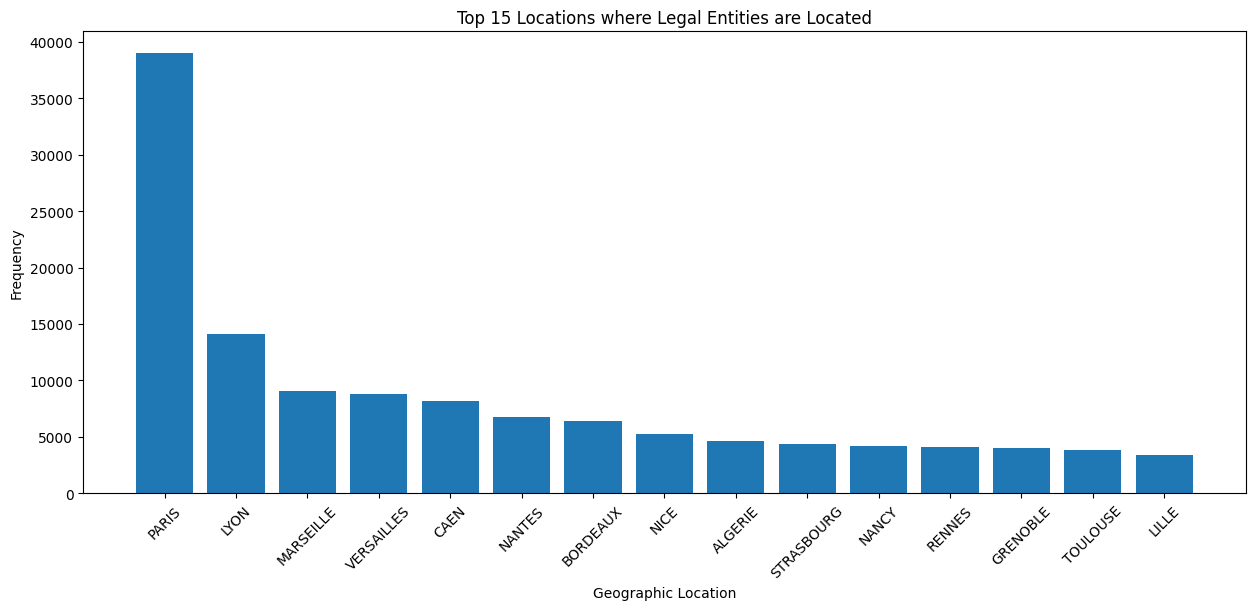

In [ ]:
def count_unique_locations(prepared_df):
    all_locations = prepared_df["Legal Entity Location"].str.cat(sep=";").split(";")
    unique_locations = set(loc.strip() for loc in all_locations)
    num_unique_locations = len(unique_locations)
    return num_unique_locations
num_unique_locations = count_unique_locations(prepared_df)
print(f"\nThere are {num_unique_locations} unique locations in the 'Legal Entity Location' column.")
print("")

def top_legal_entity_locations(prepared_df):
    print("This graph compiles the most common locations where a legal entity is based in France.")
    print("")
    all_locations = prepared_df["Legal Entity Location"].str.cat(sep=";").split(";")
    # We filtered out the country names because we were looking more for cities where the Legal Entities are located.
    # ChatGPT provided us a list of the most common countries (in their French form) to exclude.
    all_locations = [loc for loc in all_locations if loc not in ["FRANCE",
    "REPUBLIQUE FRANCAISE", "ALLEMAGNE", "ESPAGNE", "ITALIE",
    "PORTUGAL", "BELGIQUE", "LUXEMBOURG", "SUISSE", "CANADA", "AUTRICHE",
    "HONGRIE", "POLOGNE", "NORVÈGE", "SUÈDE", "FINLANDE", "DANEMARK",
    "GRÈCE", "TURQUIE", "MAROC", "ALGÉRIE", "TUNISIE", "RUSSIE",
    "UKRAINE", "BIÉLORUSSIE", "ROUMANIE", "BULGARIE", "SERBIE",
    "CROATIE", "BOSNIE-HERZÉGOVINE", "SLOVÉNIE", "MONTÉNÉGRO",
    "KOSOVO", "MACÉDOINE", "LETTONIE", "LITUANIE", "ESTONIE",
    "IRLANDE", "ROYAUME-UNI", "ISLANDE", "ÉTATS-UNIS", "MEXIQUE",
    "BRÉSIL", "ARGENTINE", "CHILI", "COLOMBIE", "VENEZUELA",
    "PEROU", "ÉQUATEUR", "BOLIVIE", "PARAGUAY", "URUGUAY",
    "AUSTRALIE", "NOUVELLE-ZÉLANDE", "INDE", "CHINE", "JAPON",
    "CORÉE DU SUD", "VIETNAM", "THAÏLANDE", "MALAISIE", "INDONÉSIE",
    "PHILIPPINES", "PAKISTAN", "BANGLADESH", "NEPAL", "IRAN",
    "IRAK", "AFGHANISTAN", "SYRIE", "LIBAN", "JORDANIE", "ISRAËL",
    "ÉGYPTE", "LYBIE", "SOMALIE", "KENYA", "ÉTHIOPIE", "NIGERIA",
    "SOUDAN", "TANZANIE", "AFRIQUE DU SUD", "NAMIBIE", "BOTSWANA",
    "ZIMBABWE", "MOZAMBIQUE", "MADAGASCAR"]]
    location_counts = Counter(all_locations)
    top_locations = dict(location_counts.most_common(15))
    plt.figure(figsize=(15, 6))
    plt.bar(top_locations.keys(), top_locations.values())
    plt.xlabel("Geographic Location")
    plt.ylabel("Frequency")
    plt.title("Top 15 Locations where Legal Entities are Located")
    plt.xticks(rotation=45)
    plt.show()

top_legal_entity_locations(prepared_df)


### 6.WHICH CHAMBERS REVIEW THE MOST CASES?


This graph outlines the top 25 Conseil Chambers by the total number of decisions they have issued.



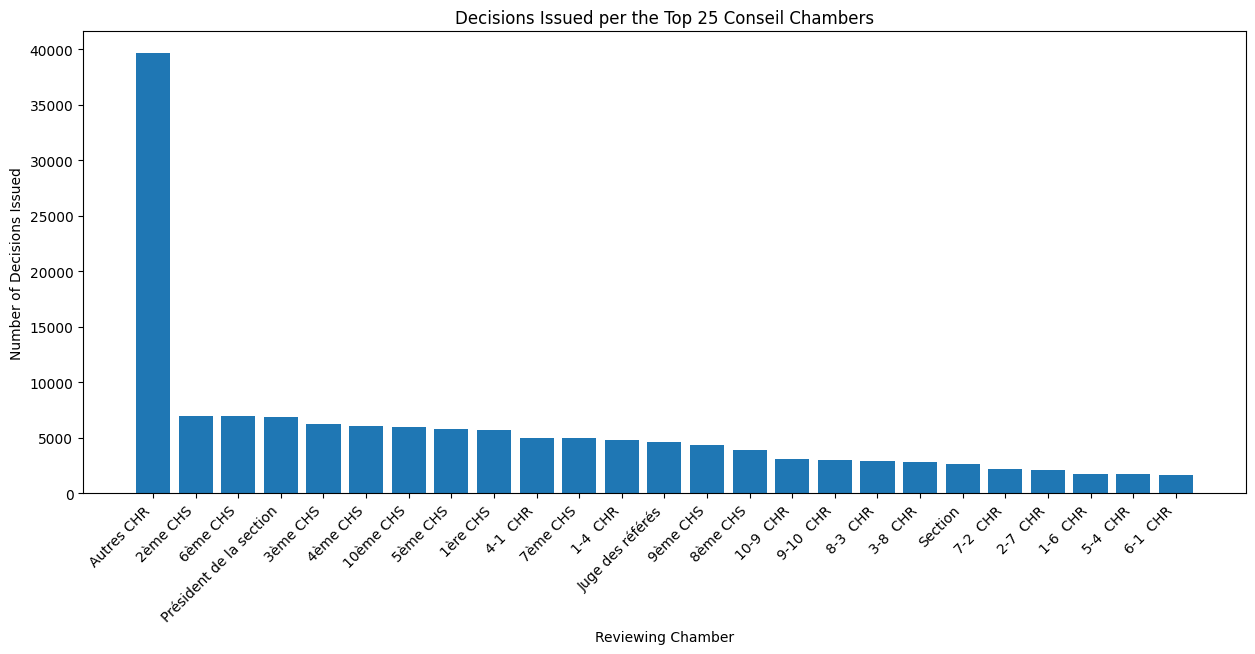

In [ ]:
def reviewing_chamber_counts(prepared_df):
    print("\nThis graph outlines the top 25 Conseil Chambers by the total number of decisions they have issued.")
    print("")
    chamber_counts = prepared_df["Reviewing Chamber"].value_counts().head(25)
    plt.figure(figsize=(15, 6))
    plt.bar(chamber_counts.index, chamber_counts.values)
    plt.xlabel("Reviewing Chamber")
    plt.ylabel("Number of Decisions Issued")
    plt.title("Decisions Issued per the Top 25 Conseil Chambers")
    plt.xticks(rotation=45, ha="right")
    plt.show()
    print("")

reviewing_chamber_counts(prepared_df)


### 7.WHICH CHAMBERS MOST OFTEN REVIEW CASES BROUGHT BY THE TOP 10 LEGAL ENTITIES?


This function graphs out the top 10 chambers that have reviewed cases for each of the top 10 legal entities, and how many decisions they have issued.



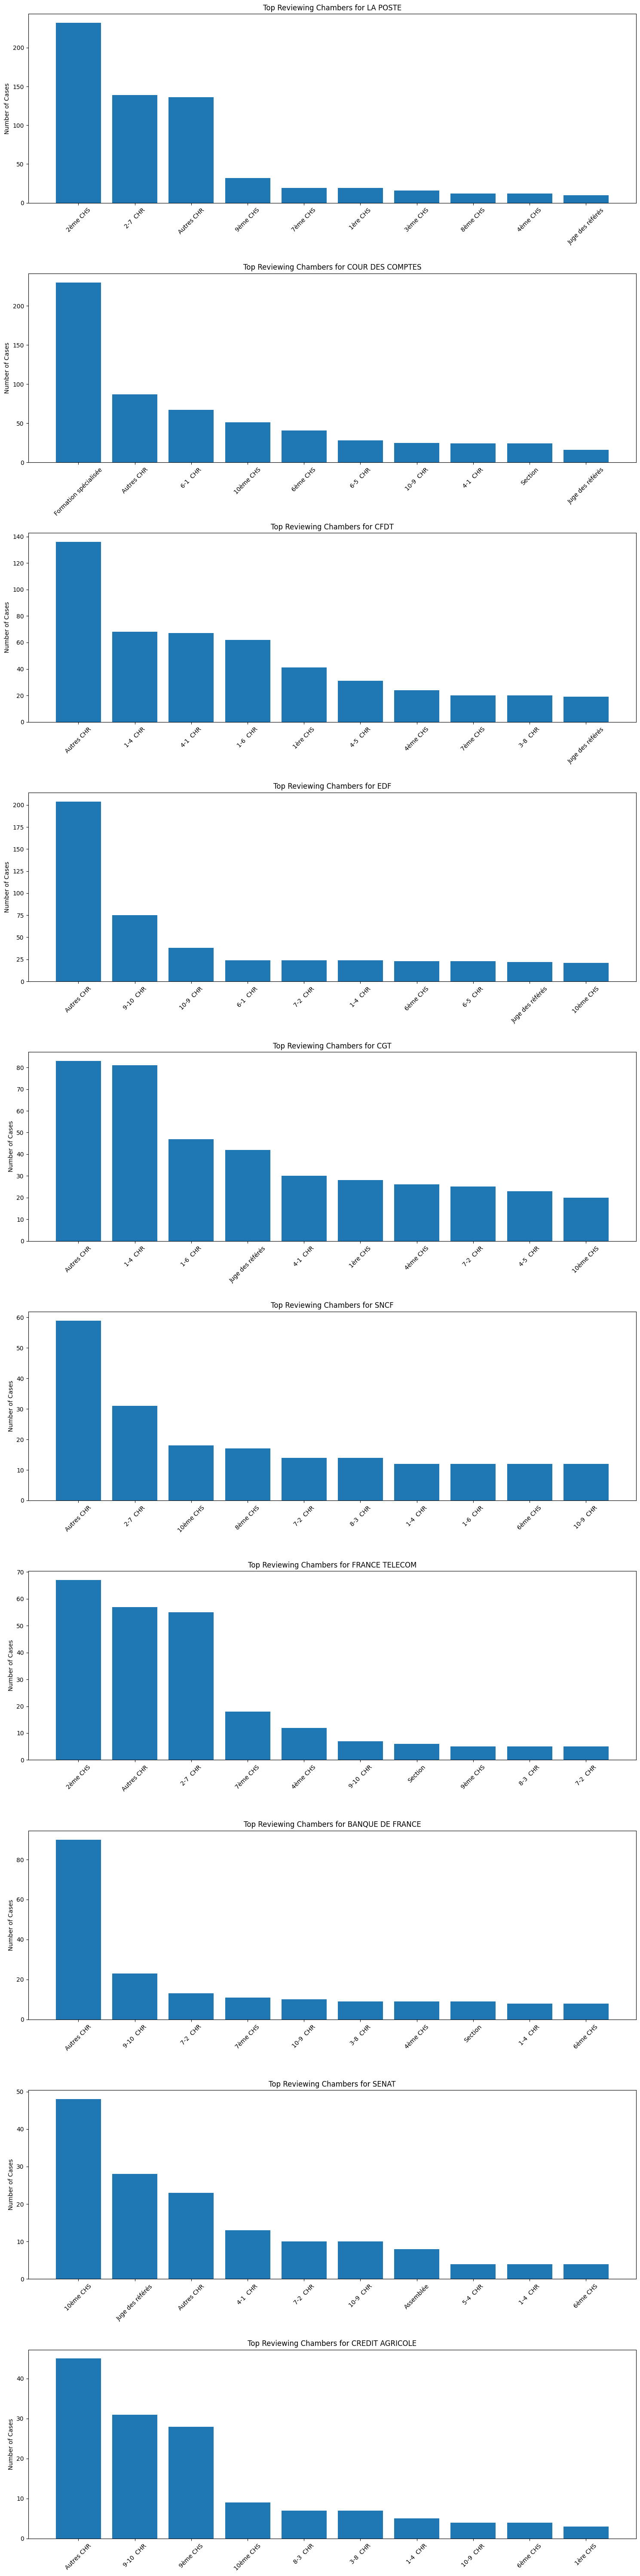

In [ ]:
def top_entities_common_chambers(prepared_df):
    print("\nThis function graphs out the top 10 chambers that have reviewed cases for each of the top 10 legal entities, and how many decisions they have issued.")
    print("")
    top_entities = prepared_df["Legal Entity"].value_counts().head(10).index
    fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(15, 60))
    for i, entity in enumerate(top_entities):
        entity_df = prepared_df[prepared_df["Legal Entity"] == entity]
        chamber_counts = entity_df["Reviewing Chamber"].value_counts().head(10)
        axes[i].bar(chamber_counts.index, chamber_counts.values)
        axes[i].set_title(f"Top Reviewing Chambers for {entity}")
        axes[i].set_ylabel("Number of Cases")
        axes[i].tick_params(axis="x", rotation=45)
    plt.tight_layout()
    plt.show()
    print("")

top_entities_common_chambers(prepared_df)


### 8.HOW SUCCESSFUL ARE THE TOP 10 LEGAL ENTITIES AT ARGUING BEFORE THE CONSEIL?

In [ ]:
# This code synthesizes out Outcomes column, which contains 1538 unique Outcome results, to make it easier for us to analyze success or fail rates.
unique_outcomes_count = prepared_df["Case Outcome"].nunique()
print(f"\nThere are {unique_outcomes_count} unique outcomes in the 'Case Outcomes' column.")
print("_______________")
print("")

# Utilized a dictionary to attempt to reduce the unique values into larger buckets. While less exact, it gave us a broader trends to analyze.
dict_outcomes = {
    "[Rr]ejet|REJET|Rejet PAPC|REJET Droits maintenus|REJET REJET Recours incident|REJET Annulation totale|Rejet - incompétence": "Rejet",
    "annulation|Annulation totale REJET Recours incident|Annulation décharge|Annulation injonction|Annulation totale renvoi|Annulation totale décharge partielle|Annulation partielle expertise|Annulation partielle décharge|Annulation partielle": "Annulation",
    "satisfaction totale|Satisfaction partielle": "Satisfaction",
    "Renvoi": "Renvoi",
    "Non-lieu|Décharge|Non-lieu à déclarer une inéligibilité": "Non-lieu",
    "Réformation|Réformation décharge|Décharge de l'imposition|Réformation Droits maintenus": "Réformation",
    "QPC": "Question Constitutionnelle Prioritaire",
    "cassation": "Cassation",
    "exécution|Condamnation astreinte": "Penalty or Exécution",
    "Avis article L. 113-1": "Avis article L. 113-1",
    "Désistement": "Désistement",
    "Avant dire-droit": "Avant dire-droit",
    "Réduction": "Réduction"
}

def apply_outcome_category(value):
    for key in dict_outcomes:
        if re.search(key, value.strip(), re.IGNORECASE):
            return dict_outcomes[key]
    return "Other"

prepared_df["Outcome Category"] = prepared_df["Case Outcome"].astype(str).apply(lambda x: apply_outcome_category(x))

print(prepared_df["Outcome Category"].value_counts())
print("_______________")
print("")
print("Below shows some of the other Case Outcomes, which are hard to classify fully into the primary buckets.")
print("")
print(prepared_df.loc[prepared_df["Outcome Category"] == "Other"]["Case Outcome"].value_counts()[:15])
print("")



There are 1539 unique outcomes in the 'Case Outcomes' column.
_______________

Other                                     82385
Rejet                                     41022
Satisfaction                               9488
Annulation                                 8353
Renvoi                                     6936
Non-lieu                                   1955
Question Constitutionnelle Prioritaire     1221
Réformation                                1165
Cassation                                   358
Penalty or Exécution                        320
Avis article L. 113-1                       251
Désistement                                 249
Avant dire-droit                            142
Réduction                                   105
Name: Outcome Category, dtype: int64
_______________

Below shows some of the other Case Outcomes, which are hard to classify fully into the primary buckets.

Avant dire droit                         77
Question préjudicielle CJCE              71
A


This graph plots the most common Case Outcomes that the Conseil's Chambers have issued to each of the Top 10 Legal Entities.



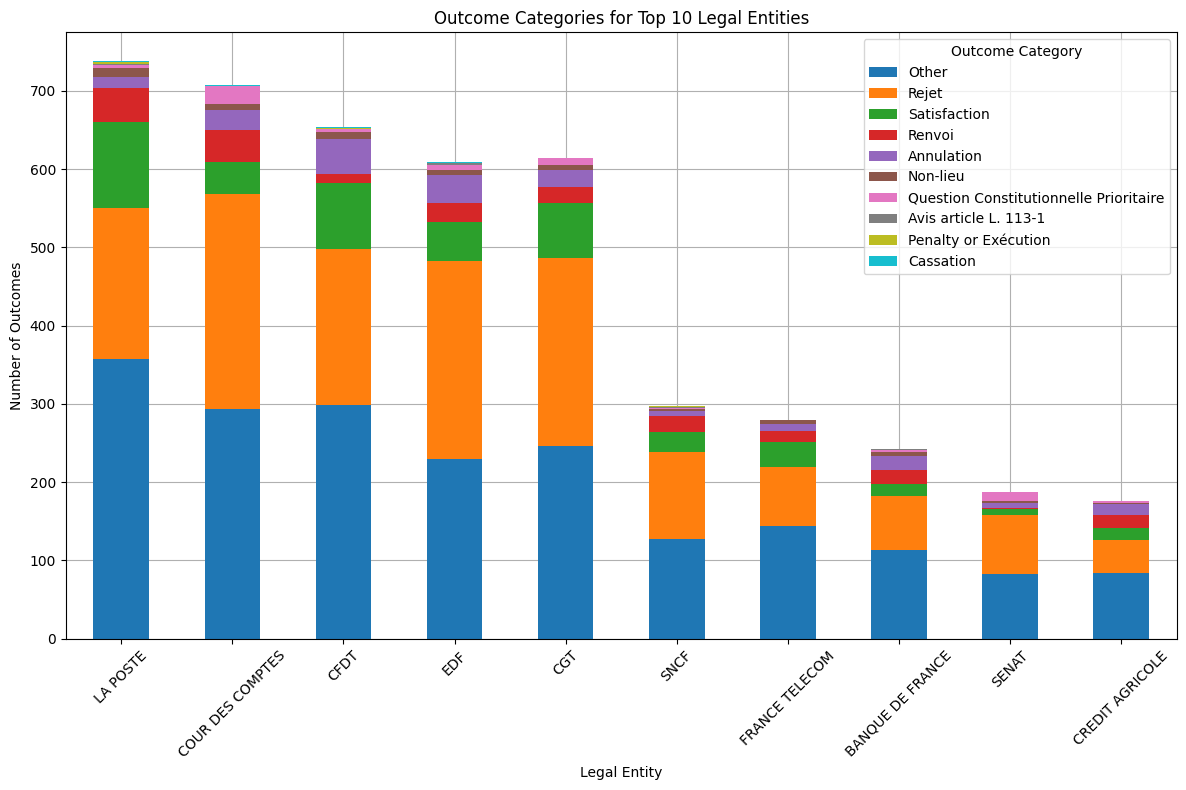


This graph displays the same information as the above graph, but by percentage.



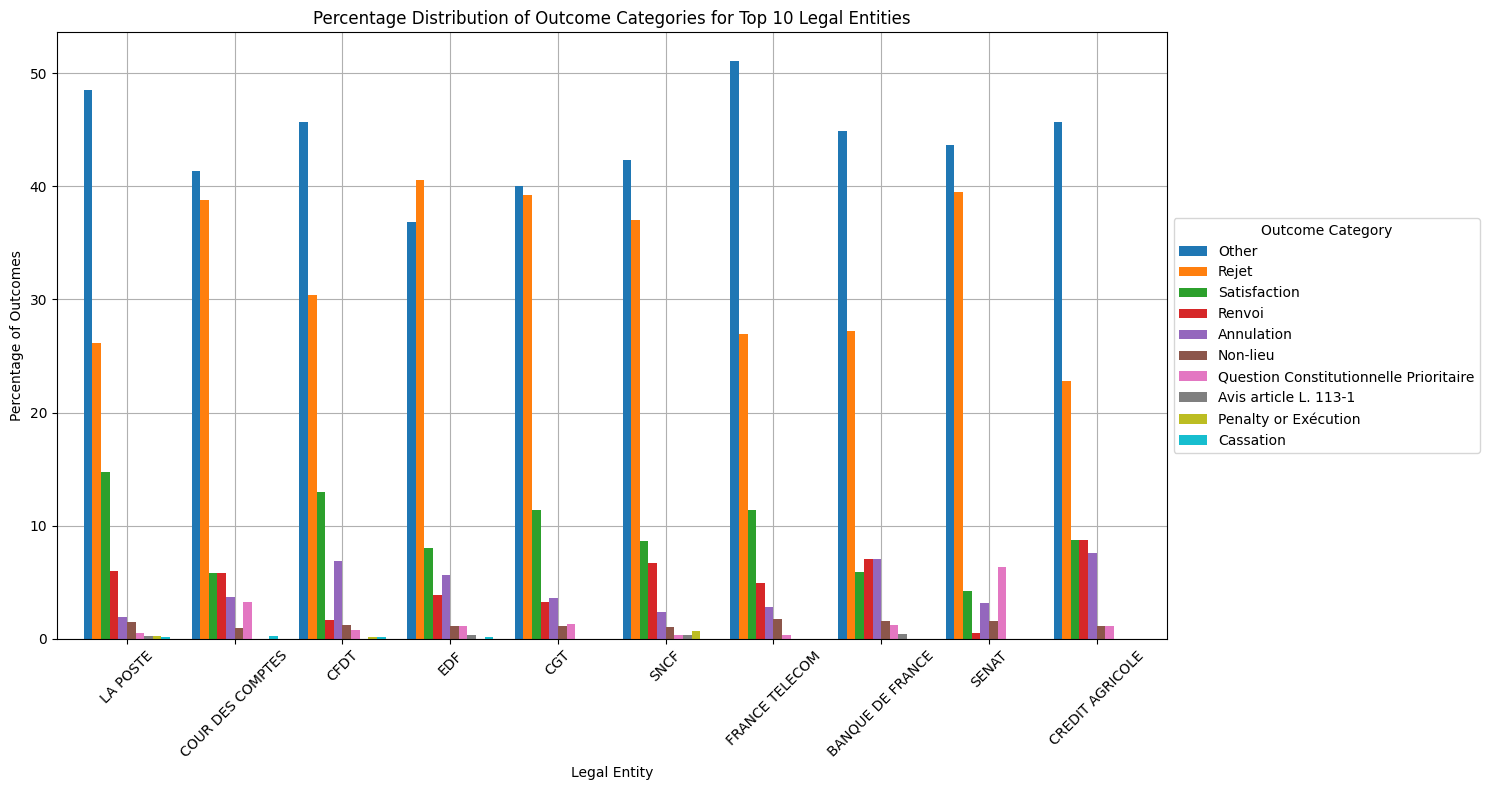

In [ ]:
def top_entities_outcome_categories(prepared_df):
    print("\nThis graph plots the most common Case Outcomes that the Conseil's Chambers have issued to each of the Top 10 Legal Entities.")
    print("")
    top_entities = prepared_df["Legal Entity"].value_counts().head(10).index
    outcome_counts = pd.DataFrame()
    for entity in top_entities:
        entity_outcomes = prepared_df[prepared_df["Legal Entity"] == entity]["Outcome Category"].value_counts()
        outcome_counts[entity] = entity_outcomes
    outcome_counts = outcome_counts.T.fillna(0)
    ax = outcome_counts.plot(kind="bar", stacked=True, figsize=(12, 8))
    plt.xlabel("Legal Entity")
    plt.ylabel("Number of Outcomes")
    plt.title("Outcome Categories for Top 10 Legal Entities")
    plt.xticks(rotation=45)
    plt.legend(title="Outcome Category", loc="upper right")
    ax.grid()
    ax.set_axisbelow(True)
    plt.tight_layout()
    plt.show()
    print("")

top_entities_outcome_categories(prepared_df)

def top_entities_outcome_percentages_separate(prepared_df):
    print("This graph displays the same information as the above graph, but by percentage.")
    print("")
    top_entities = prepared_df["Legal Entity"].value_counts().head(10).index
    outcome_percentages = pd.DataFrame()
    for entity in top_entities:
        entity_df = prepared_df[prepared_df["Legal Entity"] == entity]
        entity_outcomes = entity_df["Outcome Category"].value_counts()
        entity_total = entity_outcomes.sum()
        outcome_percentages[entity] = (entity_outcomes / entity_total * 100)  # Convert to percentage
    outcome_percentages = outcome_percentages.fillna(0).T
    ax = outcome_percentages.plot(kind="bar", figsize=(15, 8), width=0.8, stacked=False)
    plt.xlabel("Legal Entity")
    plt.ylabel("Percentage of Outcomes")
    plt.title("Percentage Distribution of Outcome Categories for Top 10 Legal Entities")
    plt.xticks(rotation=45)
    plt.legend(title="Outcome Category", loc="center left", bbox_to_anchor=(1, 0.5))
    ax.grid()
    ax.set_axisbelow(True)
    plt.tight_layout()
    plt.show()
    print("")

top_entities_outcome_percentages_separate(prepared_df)


### 9.HOW OFTEN DOES THE CONSEIL PUBLISH ITS DECISIONS? HOW OFTEN HAVE THE TOP 10 LEGAL ENTITIES BEEN PUBLISHED?


To date, there have been 15636 Type A and 25490 Type B decisions published.
In contrast, 112722 C Type decisions have not been published.

This graph plots the number of published and un-published decisions issued by the Conseil to the top 10 legal entities.



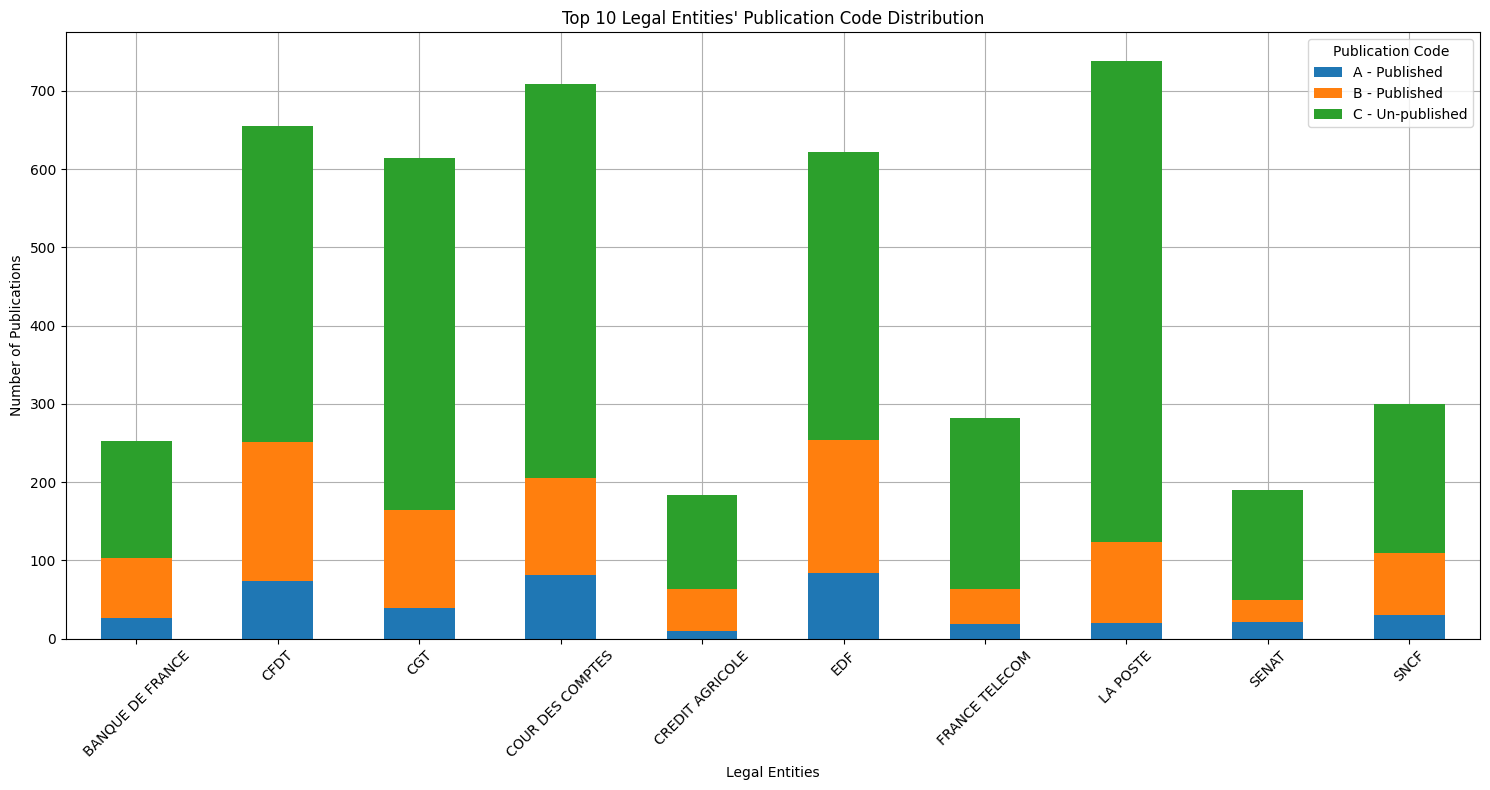

In [ ]:
def count_publication_codes(prepared_df):
    publication_counts = prepared_df["Publication Code"].value_counts()
    a_count = publication_counts.get("A", 0)
    b_count = publication_counts.get("B", 0)
    c_count = publication_counts.get("C", 0)
    return a_count, b_count, c_count

a_count, b_count, c_count = count_publication_codes(prepared_df)
print(f"\nTo date, there have been {a_count} Type A and {b_count} Type B decisions published.")
print(f"In contrast, {c_count} C Type decisions have not been published.")

count_publication_codes(prepared_df)

def top_10_pub_or_unpub_codes(prepared_df):
    print("\nThis graph plots the number of published and un-published decisions issued by the Conseil to the top 10 legal entities.")
    print("")
    top_ten_entities = prepared_df["Legal Entity"].value_counts().head(10).index
    top_ten_df = prepared_df[prepared_df["Legal Entity"].isin(top_ten_entities)]
    grouped_top_ten = top_ten_df.groupby(["Legal Entity", "Publication Code"]).size().reset_index(name="Number of Publications")
    pivot_top_ten_publication = grouped_top_ten.pivot(index="Legal Entity", columns="Publication Code", values="Number of Publications").fillna(0)
    pivot_top_ten_publication = pivot_top_ten_publication[["A", "B", "C"]]
    ax = pivot_top_ten_publication.plot(kind="bar", stacked=True, figsize=(15, 8))
    plt.xlabel("Legal Entities")
    plt.ylabel("Number of Publications")
    plt.title("Top 10 Legal Entities' Publication Code Distribution")
    plt.xticks(rotation=45)
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ["A - Published" if label == "A" else "B - Published" if label == "B" else "C - Un-published" for label in labels]
    ax.legend(handles, new_labels, title="Publication Code", bbox_to_anchor=(1, 1), loc="upper right")
    ax.grid()
    ax.set_axisbelow(True)
    plt.tight_layout()
    plt.show()
    print("")

top_10_pub_or_unpub_codes(prepared_df)


### 10.WHICH CASES BY SECTOR ARE MOST OFTEN PUBLISHED vs. UN-PUBLISHED?


This graph plots the distribution of A, B, and C publication codes per legal sector.



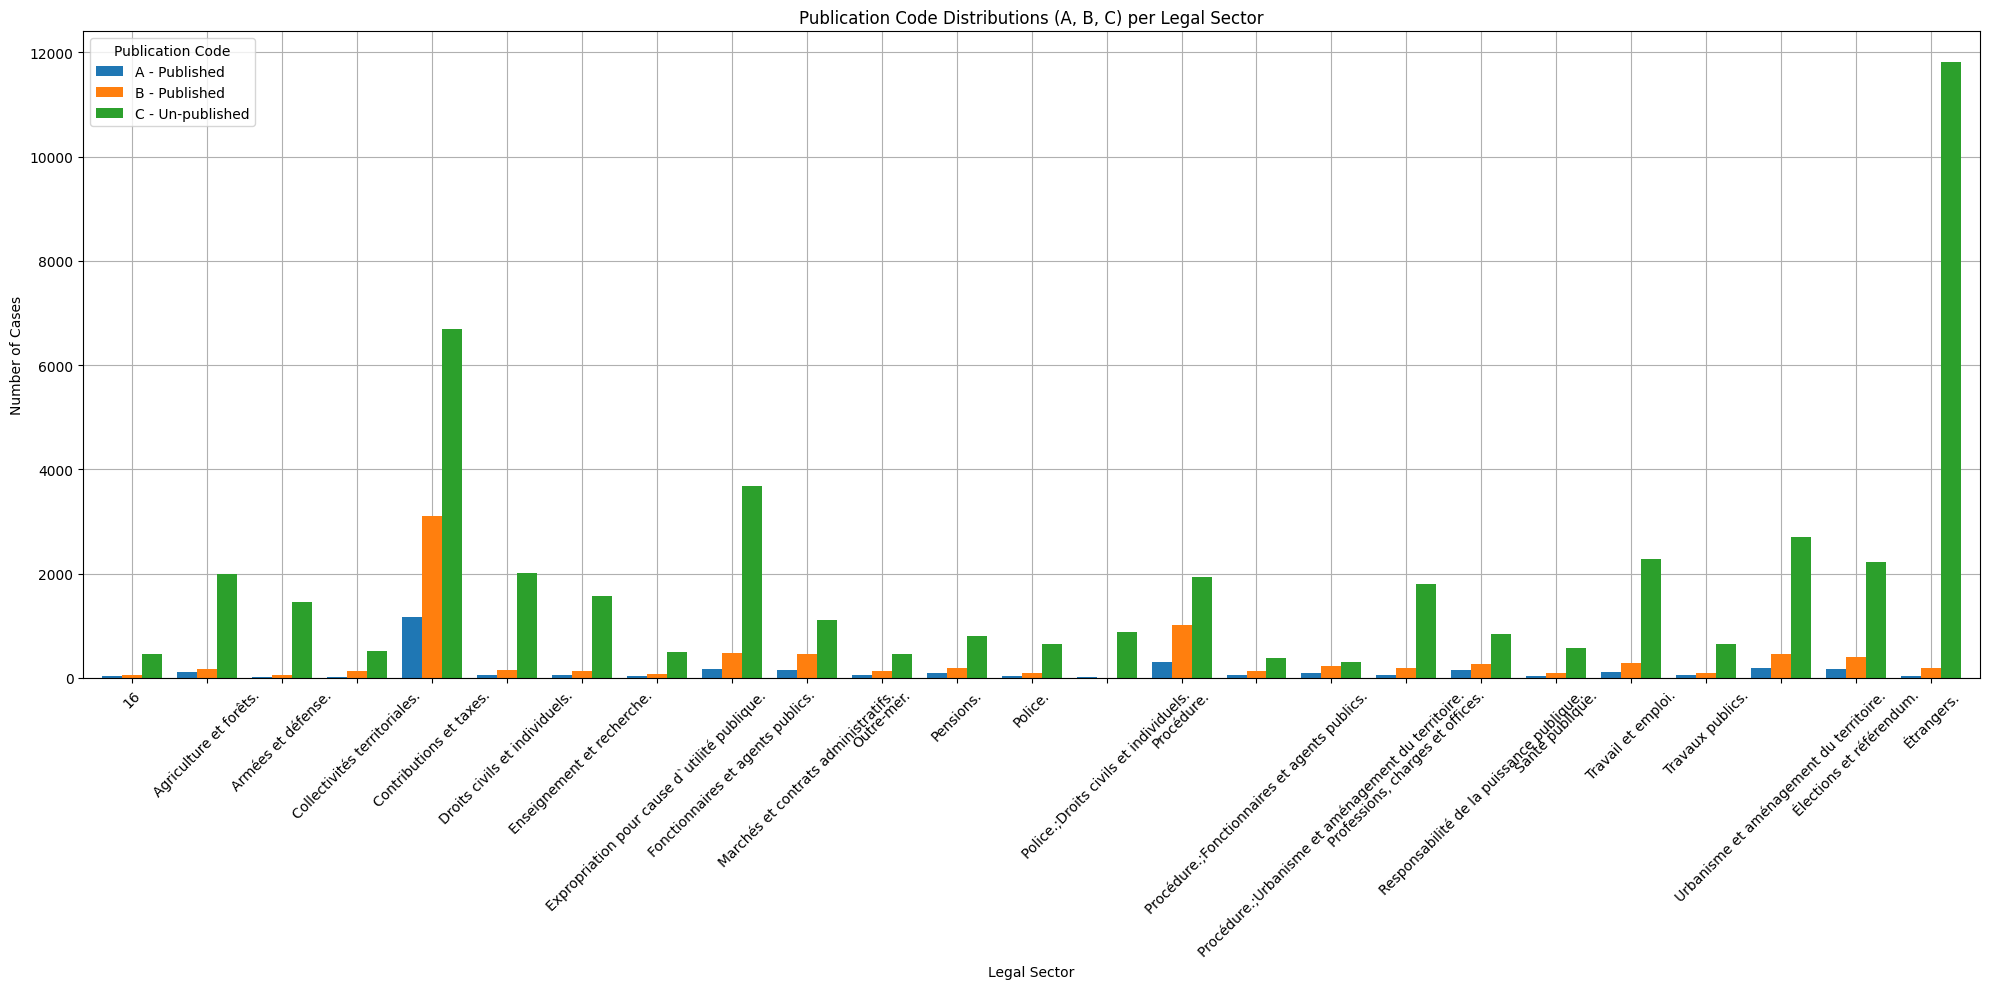

In [ ]:
def publication_codes_by_sector(prepared_df):
    print("\nThis graph plots the distribution of A, B, and C publication codes per legal sector.")
    print("")
    # This code allows us to declutter the Publication Codes per Legal Sector so that we could analyze which decisions the Conseil chose to publish.
    # We played around and set the total to only examine a Legal Sector code with more than 500 decisions (published or un-published).
    grouped = prepared_df.groupby(["Legal Sector", "Publication Code"]).size().unstack(fill_value=0)
    grouped = grouped[(grouped["A"] + grouped["B"] + grouped["C"]) >= 500]
    grouped = grouped[["A", "B", "C"]]
    ax = grouped.plot(kind='bar', stacked=False, figsize=(20, 10), width=0.8)
    plt.xlabel("Legal Sector")
    plt.ylabel("Number of Cases")
    plt.title("Publication Code Distributions (A, B, C) per Legal Sector")
    plt.xticks(rotation=45)
    plt.legend(title="Publication Code")
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ["A - Published" if label == "A" else "B - Published" if label == "B" else "C - Un-published" for label in labels]
    ax.legend(handles, new_labels, title="Publication Code")
    ax.grid()
    ax.set_axisbelow(True)
    plt.tight_layout()
    plt.show()
    print("")

publication_codes_by_sector(prepared_df)


### 11.HOW OFTEN DO THE TOP 25 CHAMBERS PUBLISH THEIR DECISIONS?


This graph highlights how often the top 25 Conseil Chambers have chosen to publish their decisions.



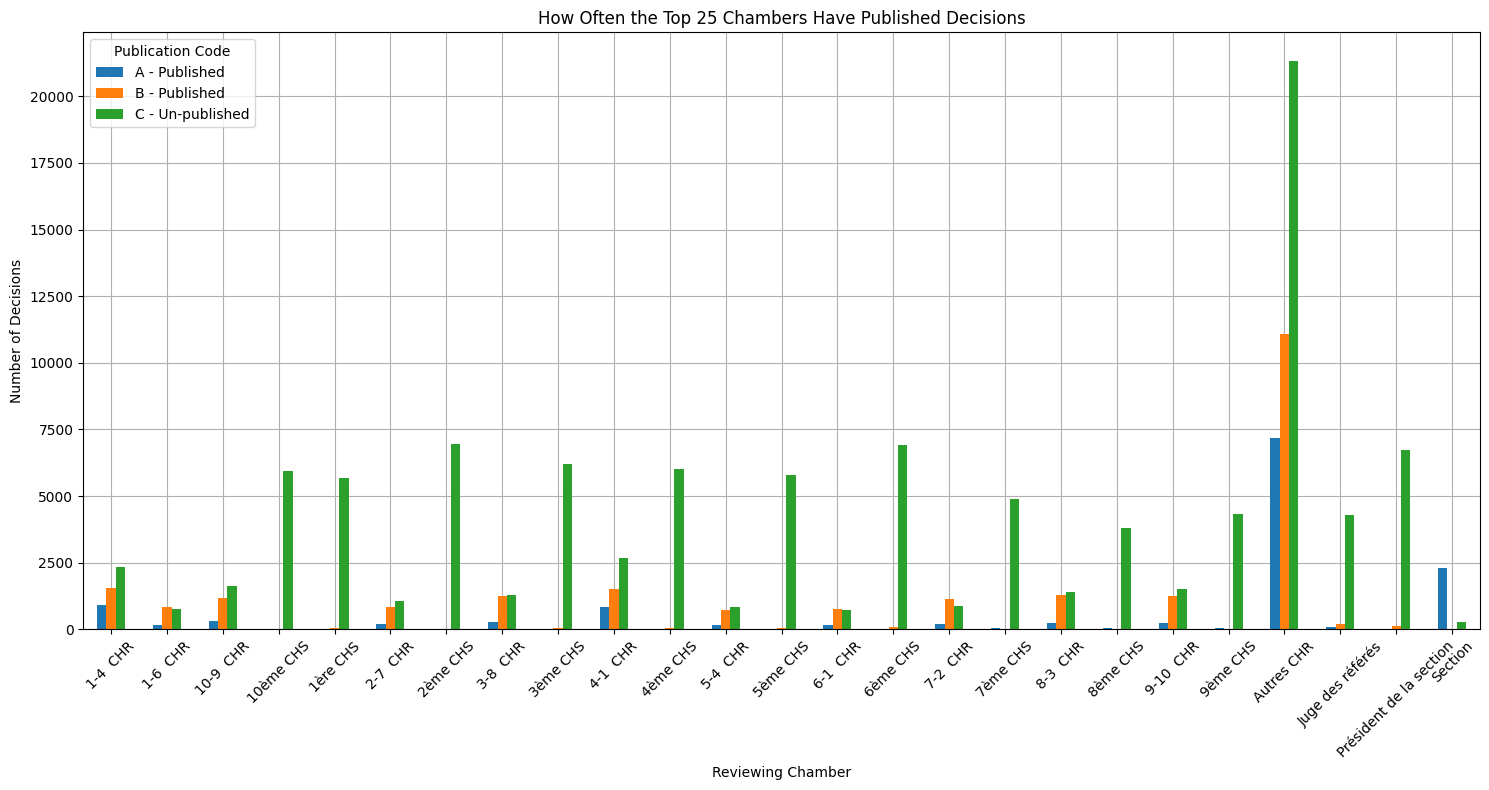

In [ ]:
def decision_types_top_chambers(prepared_df):
    print("\nThis graph highlights how often the top 25 Conseil Chambers have chosen to publish their decisions.")
    print("")
    top_chambers = prepared_df["Reviewing Chamber"].value_counts().head(25).index
    top_chambers_df = prepared_df[prepared_df["Reviewing Chamber"].isin(top_chambers)]
    grouped_counts = top_chambers_df.groupby(["Reviewing Chamber", "Publication Code"]).size().unstack(fill_value=0)
    ax = grouped_counts[["A", "B", "C"]].plot(kind="bar", stacked=False, figsize=(15, 8))
    plt.xlabel("Reviewing Chamber")
    plt.ylabel("Number of Decisions")
    plt.title("How Often the Top 25 Chambers Have Published Decisions")
    plt.xticks(rotation=45)
    handles, labels = ax.get_legend_handles_labels()
    new_labels = ["A - Published" if label == "A" else "B - Published" if label == "B" else "C - Un-published" for label in labels]
    ax.legend(handles, new_labels, title="Publication Code", loc="upper left")
    ax.grid()
    ax.set_axisbelow(True)
    plt.tight_layout()
    plt.show()
    print("")

decision_types_top_chambers(prepared_df)

### 12.WHAT ARE THE "STATS" OF LEGAL ENTITIES THAT HAVE ARGUED BEFORE THE CONSEIL?

Profile for Legal Entity: SNCF
----------------------------------------
These mini graphs provide a snapshot of the stats of a legal entity that has argued before the Conseil D'État.

Number of Appearances: 300.0



<ipython-input-32-08e471f17e21>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_xticklabels(sector_counts.index, rotation=45, ha="right")


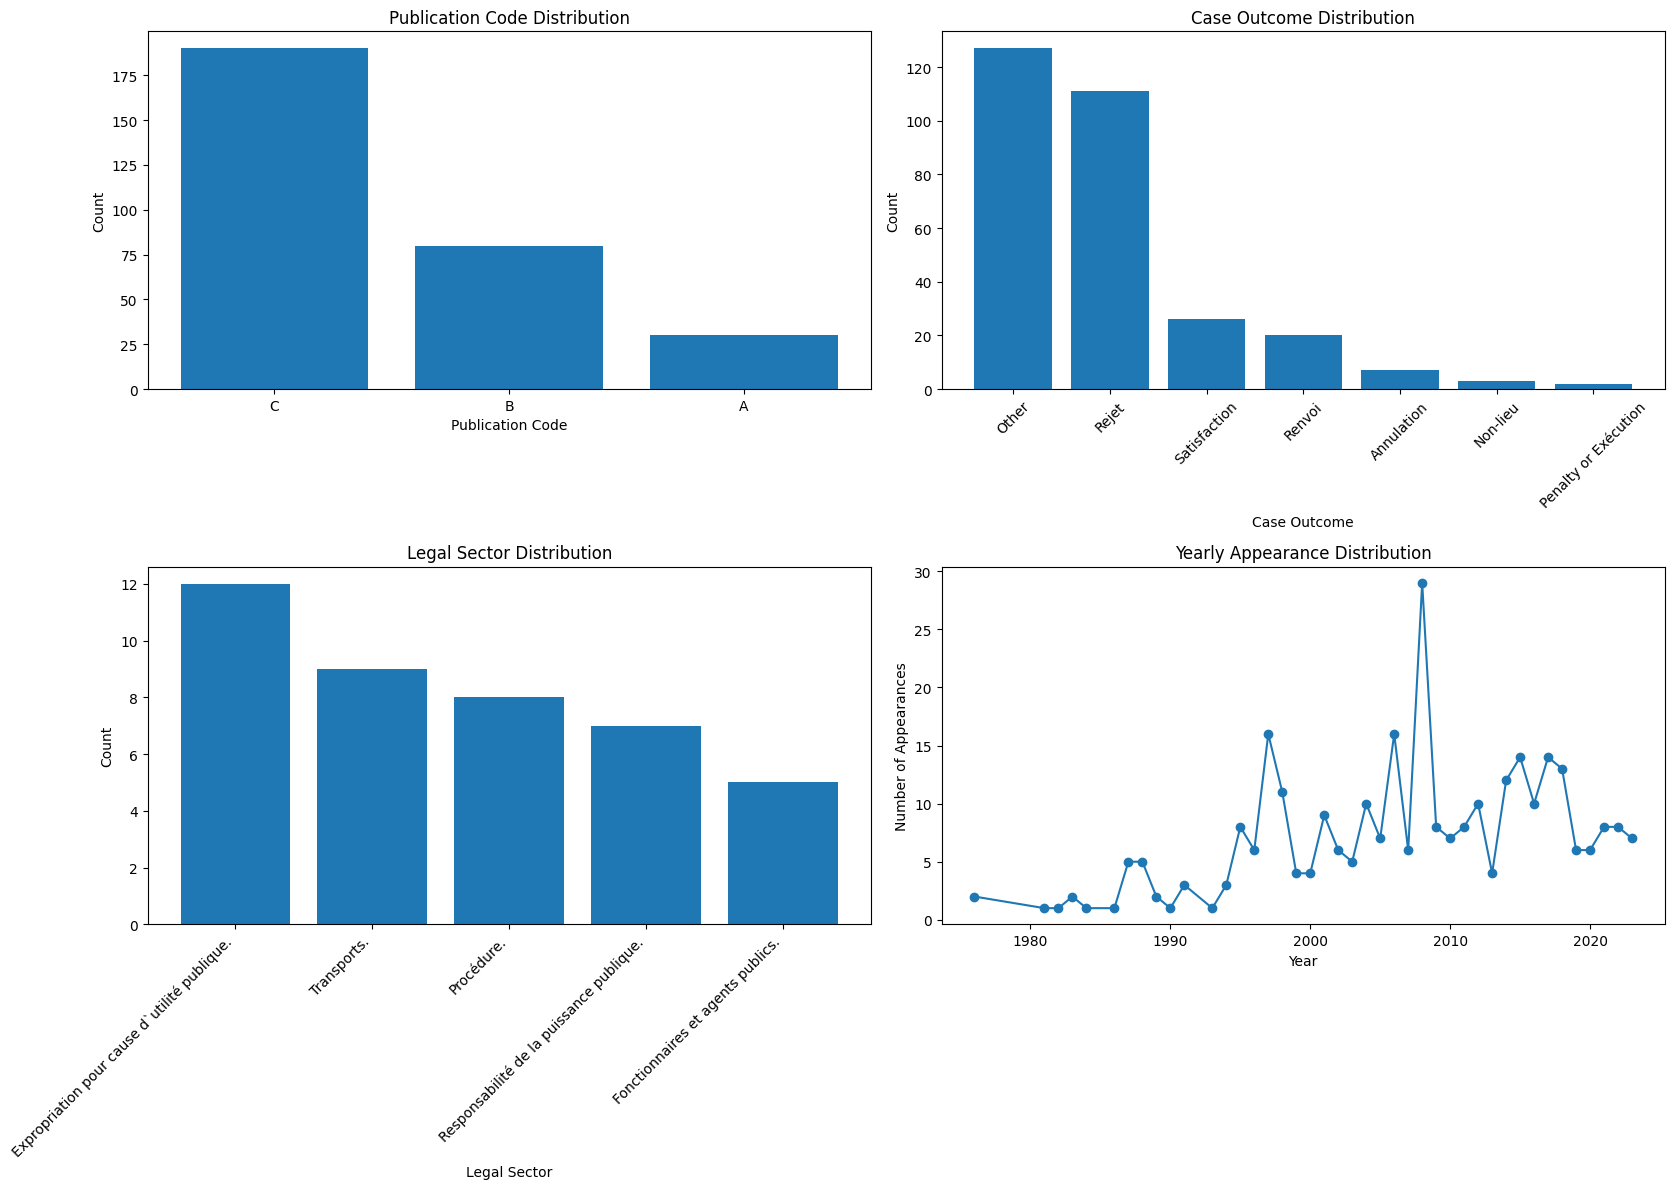

In [ ]:
# @title Number of Appearances
entity_name = "SNCF" # @param ["LA POSTE", "SNCF"] {allow-input: true}
# ChatGPT was helpful in troubleshooting issues with some of the mini graphs.
def legal_entity_profile(prepared_df, entity_name):
    if entity_name not in prepared_df['Legal Entity'].values:
        print(f"No data found for legal entity: {entity_name}")
        return
    print(f"Profile for Legal Entity: {entity_name}\n{'-'*40}")
    entity_df = prepared_df[prepared_df['Legal Entity'] == entity_name]
    print("These mini graphs provide a snapshot of the stats of a legal entity that has argued before the Conseil D'État.\n")
    print(f"Number of Appearances: {entity_df['Number of Appearances'].max()}")
    print("")
    fig, axes = plt.subplots(2, 2, figsize=(17, 12))
    # Mini graph for Publication Code
    publication_counts = entity_df["Publication Code"].value_counts()
    axes[0, 0].bar(publication_counts.index, publication_counts.values)
    axes[0, 0].set_title("Publication Code Distribution")
    axes[0, 0].set_xlabel("Publication Code")
    axes[0, 0].set_ylabel("Count")
    # Mini graph for Case Outcome
    outcome_counts = entity_df["Outcome Category"].value_counts().head(7)
    axes[0, 1].bar(outcome_counts.index, outcome_counts.values)
    axes[0, 1].set_title("Case Outcome Distribution")
    axes[0, 1].set_xlabel("Case Outcome")
    axes[0, 1].set_ylabel("Count")
    axes[0, 1].tick_params(axis="x", rotation=45)
    # Mini graph for Legal Sector
    sector_counts = entity_df["Legal Sector"].value_counts().head(5)
    axes[1, 0].bar(sector_counts.index, sector_counts.values)
    axes[1, 0].set_title("Legal Sector Distribution")
    axes[1, 0].set_xlabel("Legal Sector")
    axes[1, 0].set_ylabel("Count")
    axes[1, 0].set_xticklabels(sector_counts.index, rotation=45, ha="right")
    # Mini graph for Yearly Appearance
    year_counts = entity_df["Year Date"].value_counts().sort_index()
    axes[1, 1].plot(year_counts.index, year_counts.values, marker="o")
    axes[1, 1].set_title("Yearly Appearance Distribution")
    axes[1, 1].set_xlabel("Year")
    axes[1, 1].set_ylabel("Number of Appearances")
    plt.tight_layout()
    plt.show()
    print("")

# This code will be used to examine specific legal entities, and you can swap them out here. Note, it is case sensitive.
legal_entity_profile(prepared_df, entity_name)


### 13.HOW LONG DOES IT TAKE FROM FILING TO HEARING?

In [ ]:
# Convert 'SourceDateTime1' and 'SourceDateTime2' from string to datetime for accurate calculations.
df['SourceDateTime1'] = pd.to_datetime(df['SourceDateTime1'], errors='coerce')
df['SourceDateTime2'] = pd.to_datetime(df['SourceDateTime2'], errors='coerce')

# Calculate the time difference between the two datetime columns.
# The result will be in the form of a timedelta object.
df['TimeDifference'] = df['SourceDateTime1'] - df['SourceDateTime2']

# For ease of analysis, convert the time difference to the number of days as an integer.
df['TimeDifferenceDays'] = df['TimeDifference'].dt.days


### 14.WHAT ARE THE AVERAGE, MEDIAN, AND RANGE OF THE TIME GAP?




In [ ]:
# Calculate the average, median, and range of the time differences to understand the typical time span

# Calculate average (mean) of the time differences
average = df['TimeDifferenceDays'].mean()

# Calculate median of the time differences
median = df['TimeDifferenceDays'].median()

# Calculate the range of the time differences
# Since the range is the difference between the max and min, we use those functions
range = df['TimeDifferenceDays'].max() - df['TimeDifferenceDays'].min()

# Print out the results
print(f"Average Time Difference: {average} days")
print(f"Median Time Difference: {median} days")
print(f"Range of Time Difference: {range} days")

Average Time Difference: 452.3271048309628 days
Median Time Difference: 418.0 days
Range of Time Difference: 8265.0 days


### 15.IDENTIFY OUTLIERS

In [ ]:
# Identify outliers where the time difference is exceptionally long or short

# Calculate Q1 (25th percentile) and Q3 (75th percentile) of the time differences
Q1 = df['TimeDifferenceDays'].quantile(0.25)
Q3 = df['TimeDifferenceDays'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['TimeDifferenceDays'] < lower_bound) | (df['TimeDifferenceDays'] > upper_bound)]

# Display outliers

print(outliers['SourceCsv1'])
print(outliers['RefinedCompany'])

22                                           228952
152                                          237277
496                                          222069
509                                   223633;223634
630                                          209942
                            ...                    
157005                                433889;433890
157023                                       434441
157328                         404651;428432;441239
157506    376193;380199;380205;380206;380208;380209
158573                                       329420
Name: SourceCsv1, Length: 970, dtype: object
22                                    NaN
152                                   NaN
496                                   NaN
509                                   NaN
630                                   NaN
                       ...               
157005                                NaN
157023        BLOOMBERG;BAYER;BNP PARIBAS
157328                           LACTALIS
15750

### 16.PLOT THE OUTLIERS

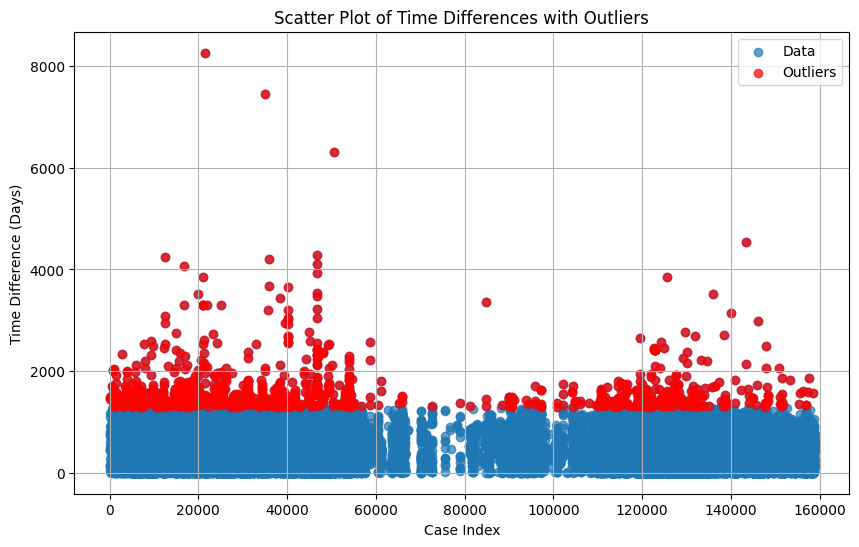

In [ ]:
# Scatter Plot with Outliers Differentiated
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['TimeDifferenceDays'], label='Data', alpha=0.7)
plt.scatter(outliers.index, outliers['TimeDifferenceDays'], color='red', label='Outliers', alpha=0.7)
plt.title('Scatter Plot of Time Differences with Outliers')
plt.xlabel('Case Index')
plt.ylabel('Time Difference (Days)')
plt.legend()
plt.grid(True)
plt.show()


### 17.PLOT THE TIME GAP

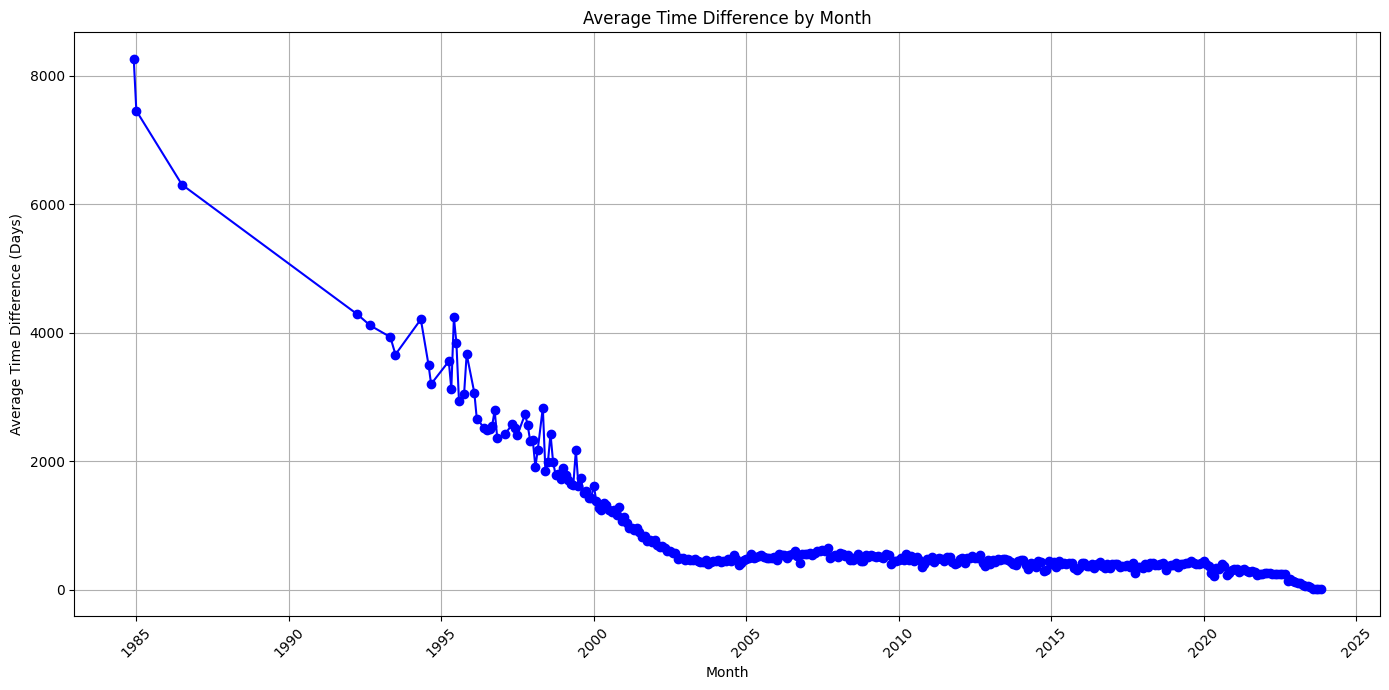

In [ ]:
# plot the time differences between two dates for each case on a monthly basis to identify trends
import matplotlib.pyplot as plt
from datetime import date

# Make sure the 'CaseDate1' and 'CaseDate2' columns are in datetime format
df['SourceDateTime1'] = pd.to_datetime(df['SourceDateTime1'])
df['SourceDateTime2'] = pd.to_datetime(df['SourceDateTime2'])


# Calculate the time difference in days between the two dates
df['TimeDifferenceDays'] = (df['SourceDateTime1'] - df['SourceDateTime2']).dt.days

# Group the DataFrame by month and year of 'SourceDateTime2'
monthly_difference = df.groupby(df['SourceDateTime2'].dt.to_period('M'))['TimeDifferenceDays'].mean()

# Convert the PeriodIndex back to DateTimeIndex for plotting
monthly_difference.index = monthly_difference.index.to_timestamp()

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(monthly_difference.index, monthly_difference.values, marker='o', linestyle='-', color='b')

plt.title('Average Time Difference by Month')
plt.xlabel('Month')
plt.ylabel('Average Time Difference (Days)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate the x-axis labels to make them more readable
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping

plt.show()

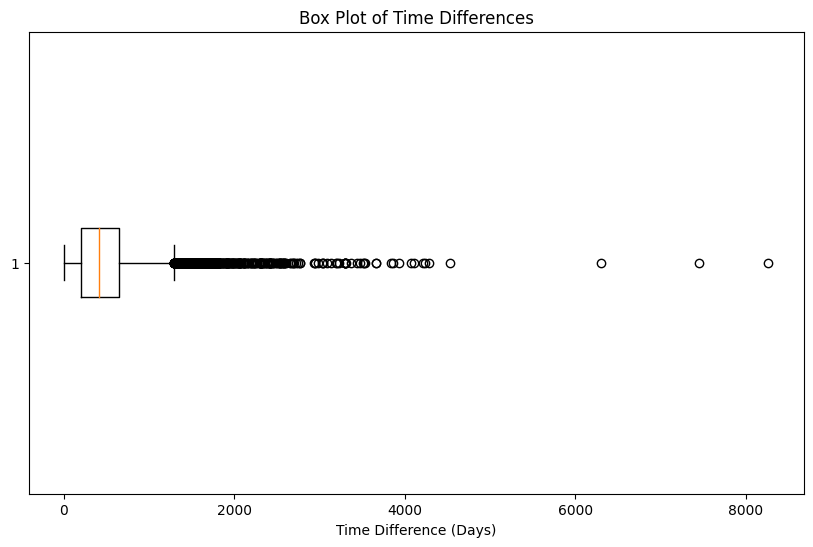

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(df['TimeDifferenceDays'].dropna(), vert=False)  # dropna() to remove NaN values
plt.title('Box Plot of Time Differences')
plt.xlabel('Time Difference (Days)')
plt.show()


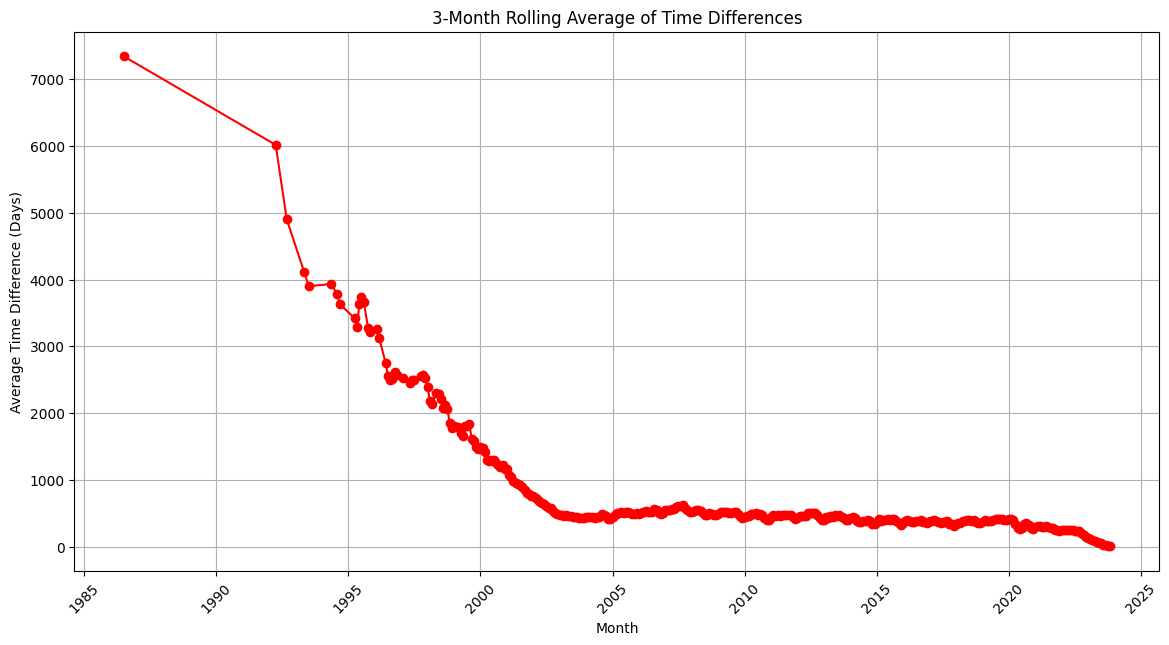

In [ ]:
plt.figure(figsize=(14, 7))
rolling_avg = monthly_difference.rolling(window=3).mean()  # 3-month rolling average
plt.plot(rolling_avg.index, rolling_avg.values, marker='o', linestyle='-', color='r')
plt.title('3-Month Rolling Average of Time Differences')
plt.xlabel('Month')
plt.ylabel('Average Time Difference (Days)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

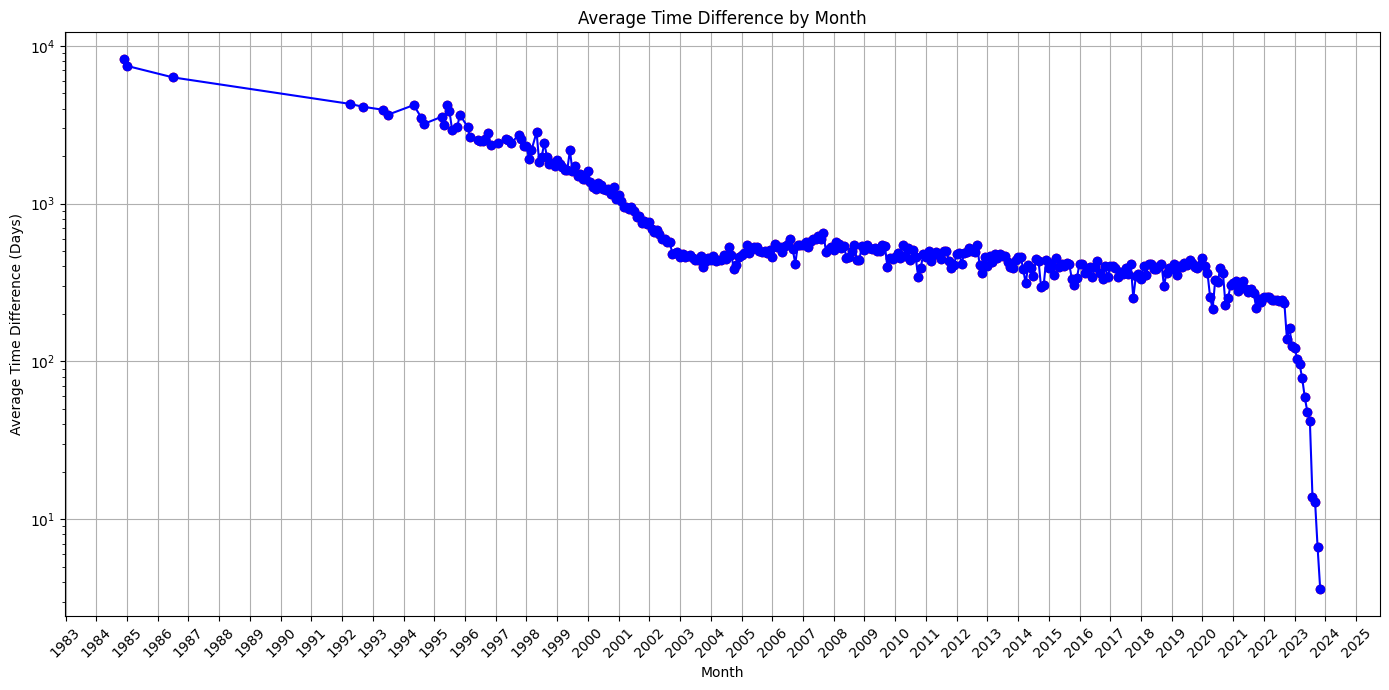

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert index to datetime for better plotting
monthly_difference.index = pd.to_datetime(monthly_difference.index)

plt.figure(figsize=(14, 7))

# Use a line plot for non-zero values
plt.plot(monthly_difference.index, monthly_difference.values, marker='o', linestyle='-', color='blue')

# Highlight non-zero points
non_zero_months = monthly_difference[monthly_difference.values != 0]
plt.scatter(non_zero_months.index, non_zero_months.values, color='red')

plt.title('Average Time Difference by Month')
plt.xlabel('Month')
plt.ylabel('Average Time Difference (Days)')

# Set the x-axis major locator and formatter
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.grid(True)
plt.yscale('log')  # Change y-scale to logarithmic to handle wide range

plt.tight_layout()  # Adjust the padding of the figure
plt.show()

### 18.HEAT MAP PLOTTING

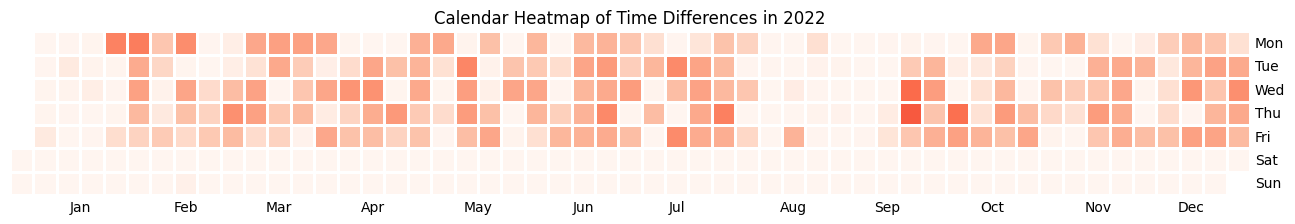

In [ ]:
# @title Calendar Heatmap of Time Differences
year = 2022 # @param {type:"number"}
!pip install calmap

daily_diff = df.resample('D', on='SourceDateTime1')['TimeDifferenceDays'].mean()

import calmap
import matplotlib.pyplot as plt

# Plotting the calendar heatmap
plt.figure(figsize=(16, 8))
calmap.yearplot(daily_diff, year=year)
plt.title(f'Calendar Heatmap of Time Differences in {year}')
plt.show()

### 19.USING REGRESSION MODELS TO PREDICT THE TIME

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# The 'TimeDifferenceDays' is our target variable and the rest are features
df['SourceDateTime1'] = pd.to_datetime(df['SourceDateTime1'], errors='coerce')
df['SourceDateTime2'] = pd.to_datetime(df['SourceDateTime2'], errors='coerce')
df['TimeDifferenceDays'] = (df['SourceDateTime1'] - df['SourceDateTime2']).dt.days

# Drop rows with NaN values before splitting
df = df.dropna()

# Define features and target
X = df.drop('TimeDifferenceDays', axis=1)  # Features
y = df['TimeDifferenceDays']  # Target

# Define numerical and categorical features
numerical_features = ['Size', 'SourceInt1']
categorical_features = ['RefinedSector', 'RefinedCompany']

# Create preprocessing pipelines
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# Fit the model with the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')


Mean Squared Error: 125247.51668245702
Root Mean Squared Error: 353.9032589316705


# Other

In [ ]:
import concurrent.futures
import logging
import os
import uuid
from datetime import datetime
from time import sleep, time

import numpy as np
import pandas as pd
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

start_time = time()

DOCUMENT_CONTENT_COLUMNS = ["Id", "DocumentId", "FetchId", "FileGroup", "FilePath", "FileName", "Content",
                            "FetchTime", "Source", "FileFormat", ]

DOCUMENT_FEATURES_COLUMNS = ["Id", "FileName", "SourceString5", "SourceString19"]


class DocumentContent:
    def __init__(self,
                 id,
                 document_id,
                 fetch_id,
                 file_group,
                 file_path,
                 file_name,
                 content,
                 fetch_time,
                 source,
                 file_format,
                 saved_date
                 ):
        self.id = id
        self.document_id = document_id
        self.fetch_id = fetch_id
        self.file_group = file_group
        self.file_path = file_path
        self.file_name = file_name
        self.content = content
        self.fetch_time = fetch_time
        self.source = source
        self.file_format = file_format
        self.saved_date = saved_date

    def to_dict(self):
        return {
            "Id": self.id,
            "DocumentId": self.document_id,
            "FetchId": self.fetch_id,
            "FileGroup": self.file_group,
            "FilePath": self.file_path,
            "FileName": self.file_name,
            "Content": self.content,
            "FetchTime": self.fetch_time,
            "Source": self.source,
            "FileFormat": self.file_format,
            "SavedDate": self.saved_date
        }


class FetchDocumentContent:

    def __init__(self,
                 input_path="../datasets/csv",
                 input_filename="documents.csv",
                 export_path_aw_dce_html="../datasets/aw_dce/html",
                 export_path_aw_ajce_html="../datasets/aw_ajce/html",
                 export_path_aw_crp_html="../datasets/aw_crp/html",
                 file_path_html="../datasets/aw_crp/html",

                 export_path_csv="../datasets/csv",
                 export_name_csv="document_contents.csv",
                 log_path_fetch="../logs/fetch",
                 log_path_process="../logs/process",

                 ):

        self.url = "https://www.conseil-etat.fr/plugin?plugin=Service.callXdownloadAW&action=Search"
        self.documents_df = pd.read_csv(f"{input_path}/{input_filename}", low_memory=False)
        self.documents_df["DocumentId"] = self.documents_df["Id"].apply(lambda x: x.replace("/Ariane_Web/", ""))

        self.total_count = len(self.documents_df)
        self.fetched_count = 0

        self.file_path_html = file_path_html
        self.export_path_aw_dce_html = export_path_aw_ajce_html
        self.export_path_aw_ajce_html = export_path_aw_ajce_html
        self.export_path_aw_crp_html = export_path_aw_crp_html

        self.file_path_csv = export_path_csv
        self.export_name_csv = export_name_csv

        self.log_path_fetch = log_path_fetch
        self.log_path_process = log_path_process
        self.log_date = datetime.now().strftime('%Y-%m-%d')

        # self.documents_df = self.documents_df[:3]

    def fetch_dce(self, document):
        try:
            logger.info(f"Document {document['Id']}: FETCHING")
            response = requests.post(self.url, json={
                "documentId": document['DocumentId'],
            })
            response.raise_for_status()
            logger.info(f"Document {document['DocumentId']} for {document['FileName']}: FETCHED")
            sleep(0.5)
            self.fetched_count += 1
            logger.info(f"Total Fetched Documents: {self.fetched_count}/{self.total_count}")
            logger.info(f"Percentage Fetched Documents: {round(self.fetched_count / self.total_count, 2) * 100}%")
            saved_date = document["SourceStr19"].split("\\")[5]

            document_content = DocumentContent(
                id=str(uuid.uuid4()),
                document_id=document['DocumentId'],
                fetch_id=document['Id'],
                file_group="AW_DCE",
                file_path=f"{self.file_path_html}/{document['FileName']}",
                file_name=document["FileName"],
                content=response.content,
                fetch_time=datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                source="ARIANE_WEB",
                file_format=document["DocFormat"],
                saved_date=saved_date,
            )
            self.export_html(response.content, document["FileName"], prefix="AW_DCE_", date=saved_date)
            return document_content.to_dict()
        except Exception as e:
            logger.error(f"Document {document['Id']}: FAILED")
            logger.error(e)
            with open(f"{self.log_path_fetch}/{self.log_date}_{document['FileName']}.txt", "a") as f:
                timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                f.write(f"{timestamp}: {e}\n")

    def fetch_crp(self, document):
        try:
            logger.info(f"Document {document['Id']}: FETCHING - CRP")
            if document["SourceCsv7"] is np.nan:
                logger.info(f"Document {document['Id']}: SKIPPED - CRP")
                return
            logger.info(f"Document {document['Id']}: FETCHING - CRP - {document['SourceCsv7']}")
            document_id = document["SourceCsv7"].replace("/Ariane_Web/", "")

            response = requests.post(self.url, json={
                "documentId": document_id,
            })
            response.raise_for_status()
            logger.info(f"Document {document['DocumentId']} for {document['FileName']}: FETCHED")
            sleep(0.5)
            logger.info(f"Total Fetched Documents: {self.fetched_count}/{self.total_count}")
            logger.info(f"Percentage Fetched Documents: {round(self.fetched_count / self.total_count, 2) * 100}%")
            saved_date = document["SourceStr19"].split("\\")[5]

            document_content = DocumentContent(
                id=str(uuid.uuid4()),
                document_id=document['DocumentId'],
                fetch_id=document['Id'],
                file_group="AW_CRP",
                file_path=f"{self.file_path_html}/{document['FileName']}",
                file_name=document["FileName"],
                content=response.content,
                fetch_time=datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                source="ARIANE_WEB",
                file_format=document["DocFormat"],
                saved_date=saved_date,
            )
            self.export_html(response.content, document["FileName"], prefix="AW_CRP_", date=saved_date)
            return document_content.to_dict()
        except Exception as e:
            logger.error(f"Document {document['Id']}: FAILED")
            logger.error(e)
            with open(f"{self.log_path_fetch}/{self.log_date}_{document['FileName']}.txt", "a") as f:
                timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                f.write(f"{timestamp}: {e}\n")

    def fetch_ajce(self, document):
        try:
            logger.info(f"Document {document['Id']}: FETCHING - AJCE")
            if document["SourceCsv6"] is np.nan:
                logger.info(f"Document {document['Id']}: SKIPPED - AJCE")
                return
            logger.info(f"Document {document['Id']}: FETCHING - AJCE - {document['SourceCsv6']}")
            document_id = document["SourceCsv6"].replace("/Ariane_Web/", "")

            response = requests.post(self.url, json={
                "documentId": document_id,
            })
            response.raise_for_status()
            logger.info(f"Document {document['DocumentId']} for {document['FileName']}: FETCHED")
            sleep(0.5)
            logger.info(f"Total Fetched Documents: {self.fetched_count}/{self.total_count}")
            logger.info(f"Percentage Fetched Documents: {round(self.fetched_count / self.total_count, 2) * 100}%")
            saved_date = document["SourceStr19"].split("\\")[5]

            document_content = DocumentContent(
                id=str(uuid.uuid4()),
                document_id=document['DocumentId'],
                fetch_id=document['Id'],
                file_group="AW_AJCE",
                file_path=f"{self.file_path_html}/{document['FileName']}",
                file_name=document["FileName"],
                content=response.content,
                fetch_time=datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                source="ARIANE_WEB",
                file_format=document["DocFormat"],
                saved_date=saved_date,
            )
            self.export_html(response.content, document["FileName"], prefix="AW_AJCE_", date=saved_date)
            return document_content.to_dict()
        except Exception as e:
            logger.error(f"Document {document['Id']}: FAILED")
            logger.error(e)
            with open(f"{self.log_path_fetch}/{self.log_date}_{document['FileName']}.txt", "a") as f:
                timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                f.write(f"{timestamp}: {e}\n")

    def fetch(self, document):
        self.fetch_dce(document)
        self.fetch_crp(document)
        self.fetch_ajce(document)

    def process(self):
        with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
            jobs = {executor.submit(self.fetch, document) for index, document in self.documents_df.iterrows()}
            for job in concurrent.futures.as_completed(jobs):
                try:
                    job.result()
                except Exception as e:
                    logger.error(e)

    def export_html(self, content, filename, prefix="", date=""):
        if date == "":
            date = datetime.now().strftime('%Y%m%d')
        else:
            date = datetime.strptime(date, '%Y%m%d').strftime('%Y%m%d')
        try:
            with open(f"{self.file_path_html}/{prefix}{date}_{filename}", "w", encoding="ISO-8859-1") as f:
                f.write(content.decode("ISO-8859-1"))
        except Exception as e:
            filename = str(filename)
            with open(f"../logs/exports/{filename.replace('html', 'txt')}", "a") as f:
                f.write(f"{e}\n")
                f.write(f"=====================\n")

    def run(self):
        try:
            self.process()
        except Exception as e:
            logger.error(e)
        print("--- %s seconds ---" % round(time() - start_time, 2))



In [ ]:
if not os.path.exists(f"{workspace_path}/html"):
  os.mkdir(f"{workspace_path}/html")

fetch_document_content = FetchDocumentContent(
    input_path=f"{workspace_path}",
    input_filename=f"{dataset_filename}",
    file_path_html=f"{workspace_path}/html"
)
# fetch_document_content.run()